In [1]:
try:
    import xgboost as xgb
    import lightgbm as lgb
    import catboost as cgb
    import shap
except:
    !pip install -q xgboost lightgbm catboost shap
    import xgboost as xgb
    import lightgbm as lgb
    import catboost as cgb
    import shap


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# !pip install -qq -U hvplot
# import hvplot.pandas
# hvplot.extension('matplotlib')

## -- Device-Agnostic for GPU --
import torch
print(f"ℹ️ Running on Cuda: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
    from cuml.preprocessing import TargetEncoder as cuTE
else:
    pass

ℹ️ Running on Cuda: False


In [3]:
## -- System dependencies --
import sys, os, gc

## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

## -- Functional Tools --
from time import time, sleep
from tqdm.notebook import tqdm
from itertools import combinations, product

## -- Machine Learning --
import sklearn
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

import warnings

In [4]:
print(f"xgboost  version: {xgb.__version__}")
print(f"lightgbm version: {lgb.__version__}")
print(f"catboost version: {cgb.__version__}")

xgboost  version: 3.1.3
lightgbm version: 4.6.0
catboost version: 1.2.8


In [5]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use('ggplot')
sns.set_style("whitegrid")
# 3 '#FFA10A'
PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [6]:
### Load Data ###
PATH = '/kaggle/input/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()

ORIG_PATH = '/kaggle/input/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

train[TARGET] = train[TARGET].map({'Presence': 1, 'Absence': 0})
orig[TARGET]  = orig[TARGET].map({'Presence': 1, 'Absence': 0})

NUMS = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
CATS = [c for c in test.columns if c not in NUMS]
BASE = NUMS + CATS

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [7]:
# ## -- Check if id is unique --
# print(f"Train ID column is Unique: {train.id.is_unique}")
# print(f"Test ID column is Unique: {test.id.is_unique}")

In [8]:
display(train.head())
train.info()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: float64(1), 

In [9]:
train.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
Age,630000.0,54.136706,8.256301,29.0,48.0,54.0,60.0,77.0
Sex,630000.0,0.714735,0.451541,0.0,0.0,1.0,1.0,1.0
Chest pain type,630000.0,3.312752,0.851615,1.0,3.0,4.0,4.0,4.0
BP,630000.0,130.497433,14.975802,94.0,120.0,130.0,140.0,200.0
Cholesterol,630000.0,245.011814,33.681581,126.0,223.0,243.0,269.0,564.0
FBS over 120,630000.0,0.079987,0.271274,0.0,0.0,0.0,0.0,1.0
EKG results,630000.0,0.981660,0.998783,0.0,0.0,0.0,2.0,2.0
Max HR,630000.0,152.816763,19.112927,71.0,142.0,157.0,166.0,202.0
Exercise angina,630000.0,0.273725,0.445870,0.0,0.0,0.0,1.0,1.0
ST depression,630000.0,0.716028,0.948472,0.0,0.0,0.1,1.4,6.2


In [10]:
display(test.head())
test.info()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,43,1,1,138,267,0,0,163,0,1.8,2,0,7


<class 'pandas.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      270000 non-null  int64  
 1   Sex                      270000 non-null  int64  
 2   Chest pain type          270000 non-null  int64  
 3   BP                       270000 non-null  int64  
 4   Cholesterol              270000 non-null  int64  
 5   FBS over 120             270000 non-null  int64  
 6   EKG results              270000 non-null  int64  
 7   Max HR                   270000 non-null  int64  
 8   Exercise angina          270000 non-null  int64  
 9   ST depression            270000 non-null  float64
 10  Slope of ST              270000 non-null  int64  
 11  Number of vessels fluro  270000 non-null  int64  
 12  Thallium                 270000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 26.8 MB


In [11]:
orig.info()

<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage

In [12]:
# Check if column names are the same regardless of order
are_same_set = set(train.columns) == set(orig.columns)
print(f"Are column names the same regardless of order (train vs orig)? {are_same_set}")

# Check if column names are the same and in the same order
are_same_exact = train.columns.equals(orig.columns)
print(f"Are column names exactly the same and in the same order (train vs orig)? {are_same_exact}")

Are column names the same regardless of order (train vs orig)? True
Are column names exactly the same and in the same order (train vs orig)? True


In [13]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in BASE:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='bone')

,Age,BP,Cholesterol,Max HR,ST depression,Sex,Chest pain type,FBS over 120,EKG results,Exercise angina,Slope of ST,Number of vessels fluro,Thallium
Train,42,66,150,93,66,2,4,2,3,2,3,4,3
Original,41,47,144,90,39,2,4,2,3,2,3,4,3
Test,43,64,145,92,64,2,4,2,3,2,3,4,3


### YDATA-PROFILE REPORT

In [14]:
# # %%capture
# ## -- Comprehensive EDA --
# !{sys.executable} -m pip install -qq -U ydata-profiling[notebook]
# !pip install -qq jupyter-contrib-nbextensions
# !jupyter nbextension enable --py widgetsnbextension

In [15]:
# from ydata_profiling import ProfileReport, compare

# ## -- Single EDA --
# # profile_df = ProfileReport(train, title="Insights into TARGET Types", explorative=True)
# # profile_df.to_notebook_iframe()

# # profile_df.to_file("Loan_EDA_Report.html")

# ## -- Create Profiles for Datasets --
# train_report = ProfileReport(train, title="Train", explorative=True)
# # test_report = ProfileReport(test, title="Test", explorative=True)
# orig_report = ProfileReport(orig, title="Original", explorative=True)

# ## -- Compare 2++ Datasets --
# comparison_report = compare([train_report, test_report])

# # ## -- Obtain merged statistics (Don't know its purpose yet)
# # statistics = comparison_report.get_description()
# ## -- Save report to file
# comparison_report.to_file("Student Test Scores | Train-Orig_Stats.html")
# comparison_report.to_notebook_iframe()

# EDA

## ~ NUMERIC

In [16]:
# ## -- PLOT TARGET DISTRIBUTION --
# # plt.figure(figsize=(16, 6))
# _, axs = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios':[0.7, 0.3], 'wspace':0.1})

# ## -- KDEs --
# sns.kdeplot(data=train, x=TARGET, color=PALETTE[0], linewidth=2, ax=axs[0], label='Train')
# sns.kdeplot(data=orig, x=TARGET, color=PALETTE[1], linewidth=2, ax=axs[0], label='Original')
# axs[0].legend()
# axs[0].set_xlabel('')

# # Boxplots
# # pd.concat([train[[TARGET]], orig[[TARGET]]], axis=1).boxplot(
# #     widths=0.6,
# #     showmeans=True,
# #     # meanline=True,
# #     # patch_artist=True,
# #     # notch=True,
# #     # labels=['Train', 'Original'],
# #     ax=axs[1])

# sns.violinplot(
#     data=[train[TARGET].values, orig[TARGET].values],
#     inner='quart',
#     width=0.6,
#     # size=1,
#     # width=0.6,
#     # linewidth=2,
#     # fliersize=.1,
#     ax=axs[1],
#     palette=PALETTE)

# axs[1].set_xticklabels(['Train', 'Original'], fontdict={'weight': 'bold'})

# plt.suptitle(f"- Target '{TARGET}' distribution -", fontsize=15, fontweight='bold')
# plt.tight_layout()
# plt.show()

In [17]:
def distplots_data(train: pd.DataFrame, test: pd.DataFrame, orig: pd.DataFrame, features: list[str]):
    # 1) Concatenate data
    df = pd.concat([
            train[features].assign(Source='Train'),
            test[features].assign(Source='Test'),
            orig[features].assign(Source='Original')
    ], ignore_index=True)
    
    for i, col in enumerate(features):
        _, axs = plt.subplots(
            1, 2,
            figsize=(16, 4),
            gridspec_kw={'hspace': 0.3, 'wspace': 0.15, 'width_ratios': [0.7, 0.3]}
        )
        ## -- KDE plots --
        sns.kdeplot(data=train, x=col, linewidth=2, ax=axs[0], label='Train')
        sns.kdeplot(data=test, x=col, linewidth=2, ax=axs[0], label='Test')
        sns.kdeplot(data=orig, x=col, linewidth=2, ax=axs[0], label='Orig')
        axs[0].set_title(f'\n{col}', fontdict={'size': 15, 'weight': 'bold'})
        axs[0].set(xlabel='')
        axs[0].legend()

        ## -- BOX plots --
        sns.boxplot(
            data=df,
            y=col,
            x='Source',
            width=0.5,
            linewidth=2,
            ax=axs[1],
            palette=PALETTE
        )
        axs[1].set(xlabel='')
        axs[1].tick_params(axis='both', which='major')
        axs[1].set_xticklabels(['Train', 'Test', 'Original'], fontweight='semibold')

    plt.tight_layout()
    plt.show()

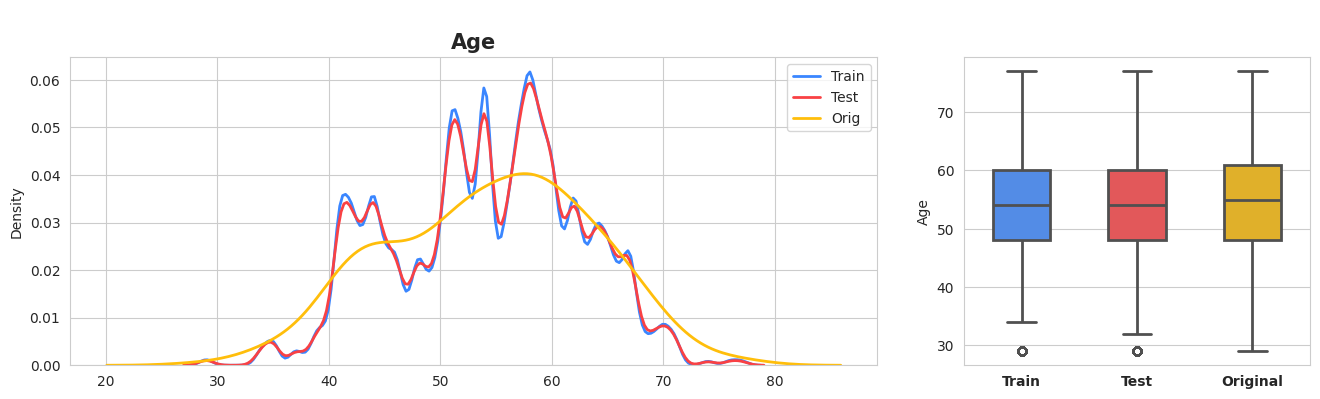

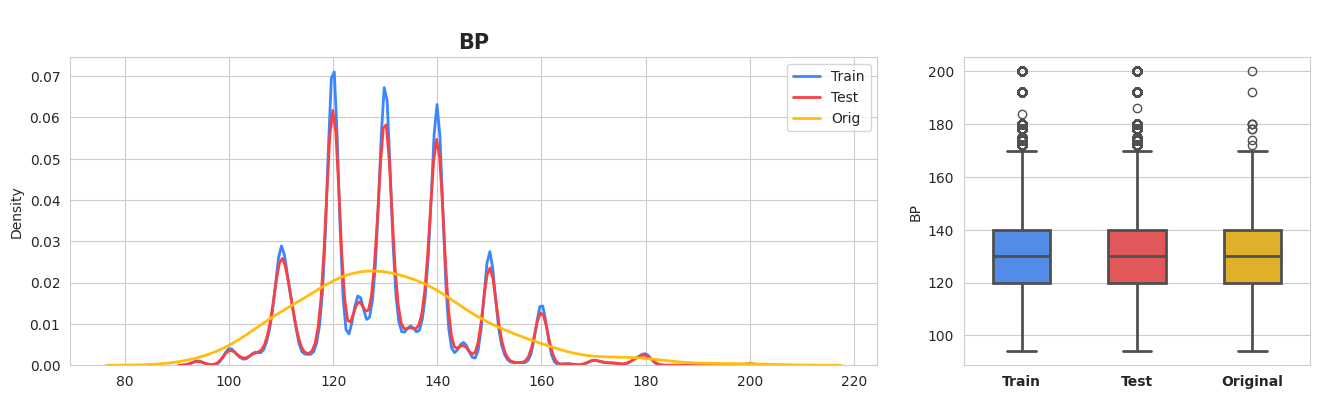

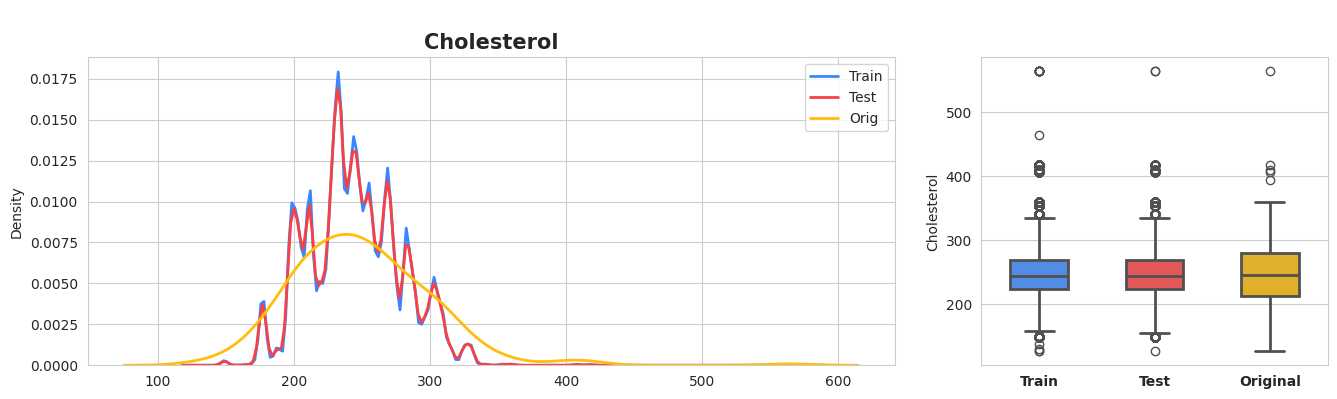

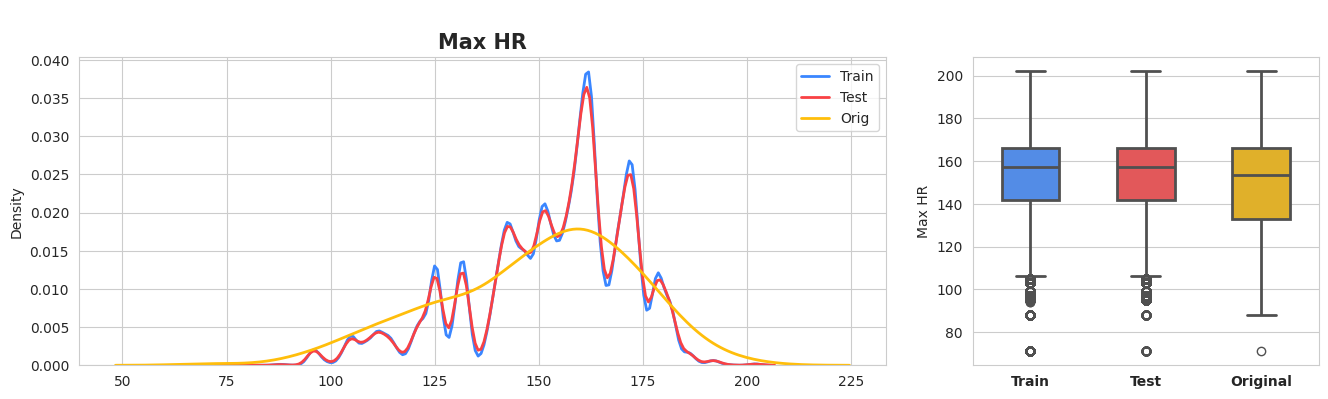

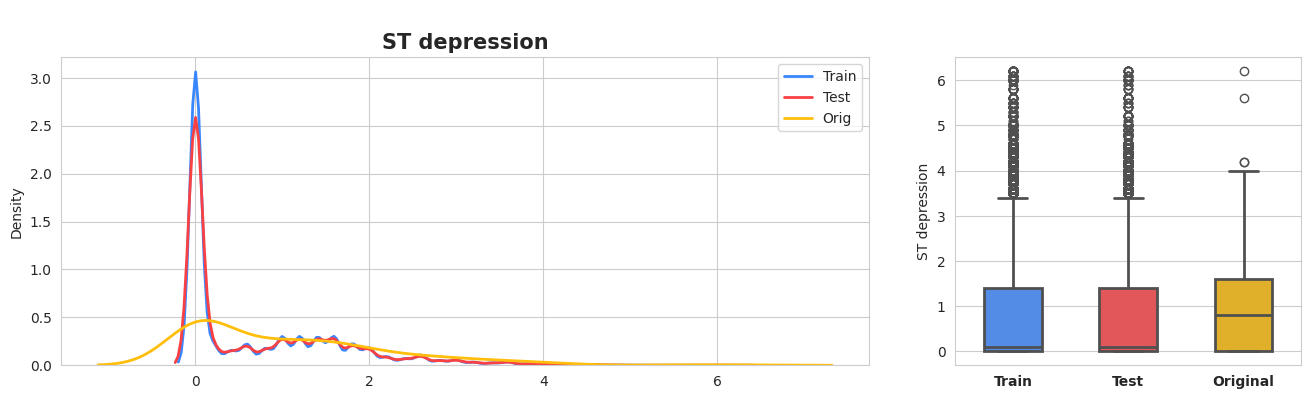

In [18]:
distplots_data(train, test, orig, NUMS)

## ~ CATEGORICAL

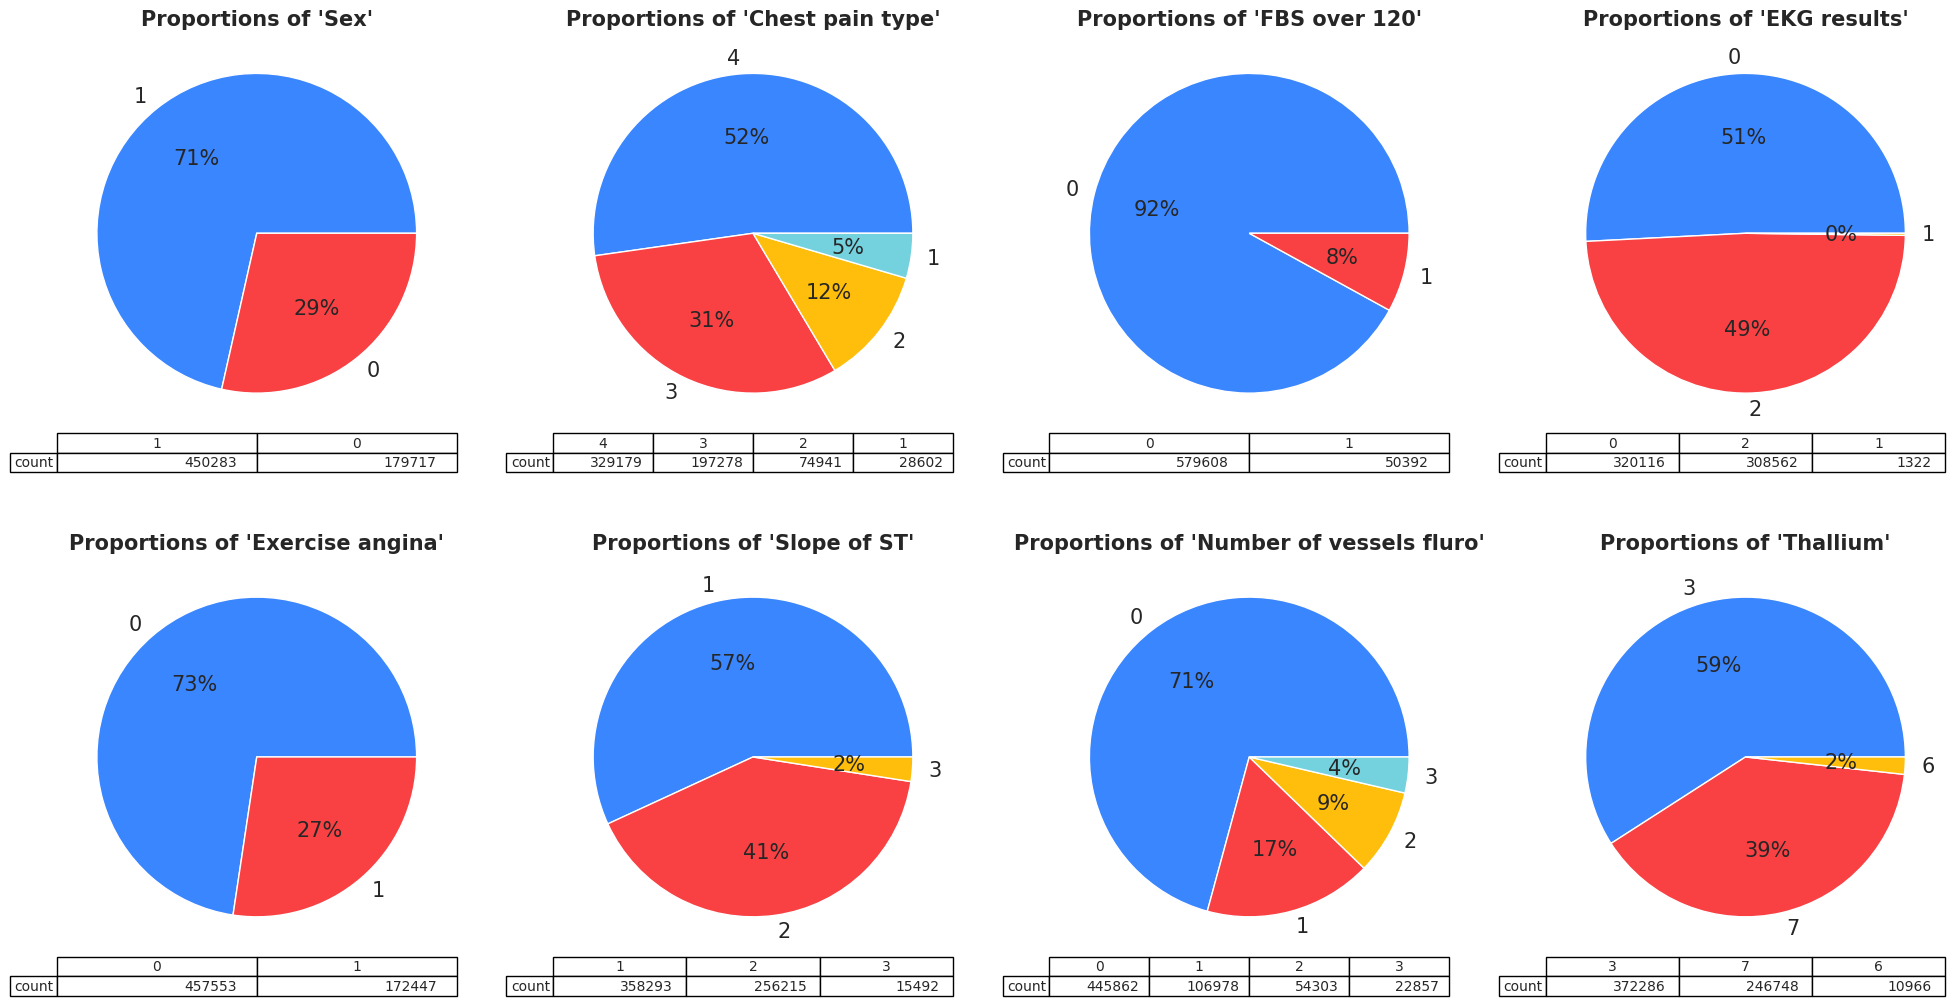

In [19]:
## -- Categorical Features --
plt.figure(figsize=(20, 15))
for i, col in enumerate(CATS):
    plt.subplot(3, 4, i+1)
    values=train[col].value_counts(dropna=False)
    values.plot.pie(autopct='%1.0f%%', fontsize=15, table=True)
    plt.title(f"Proportions of '{col}'", fontdict={'size':15, 'weight': 'bold'})
    plt.axis('off')

plt.tight_layout(h_pad=5.0)
plt.show()

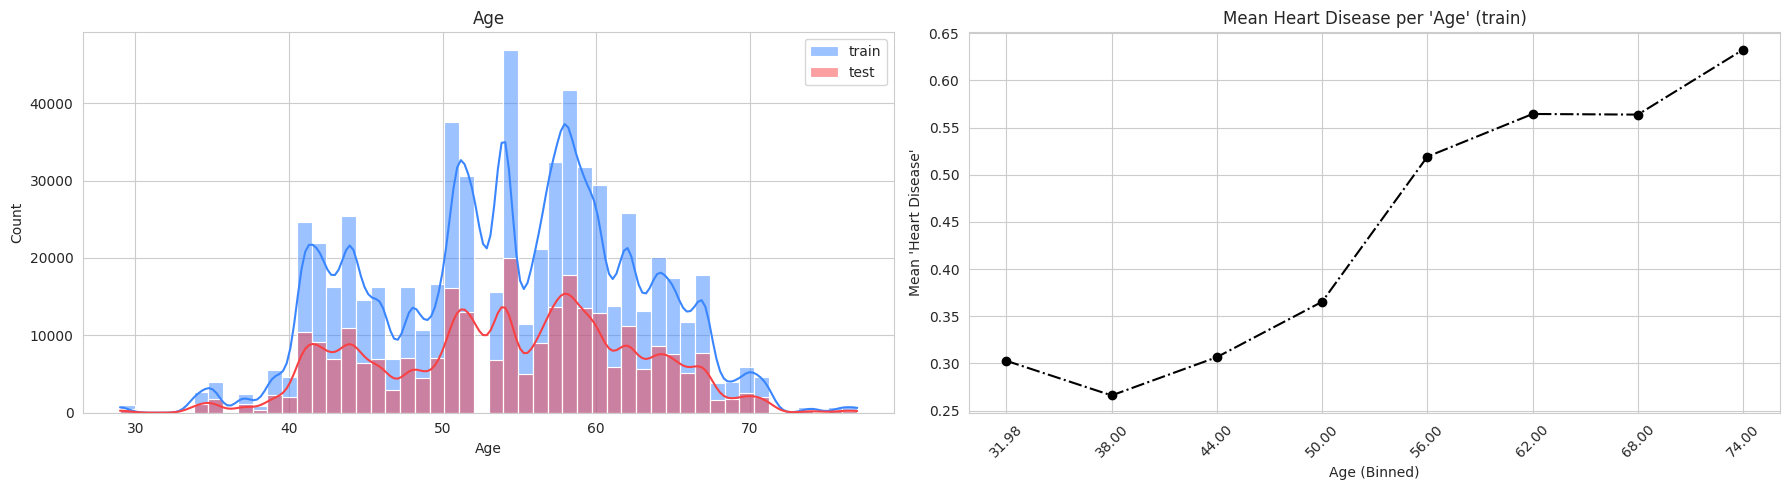

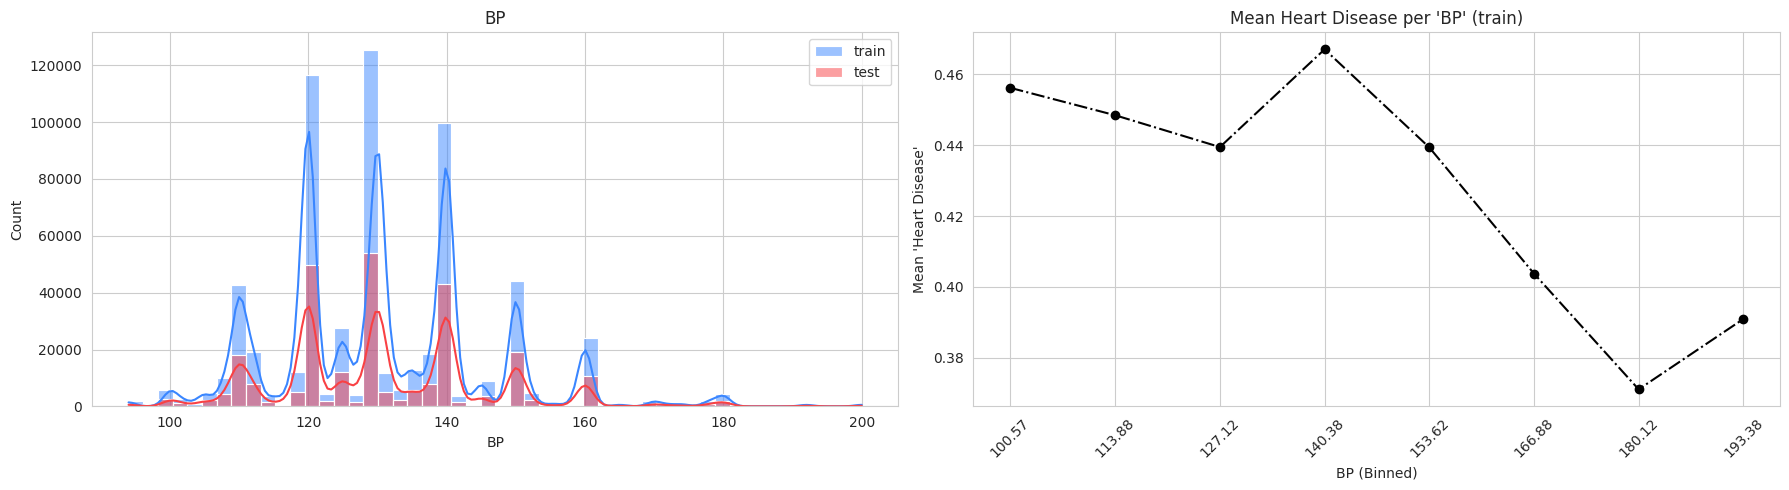

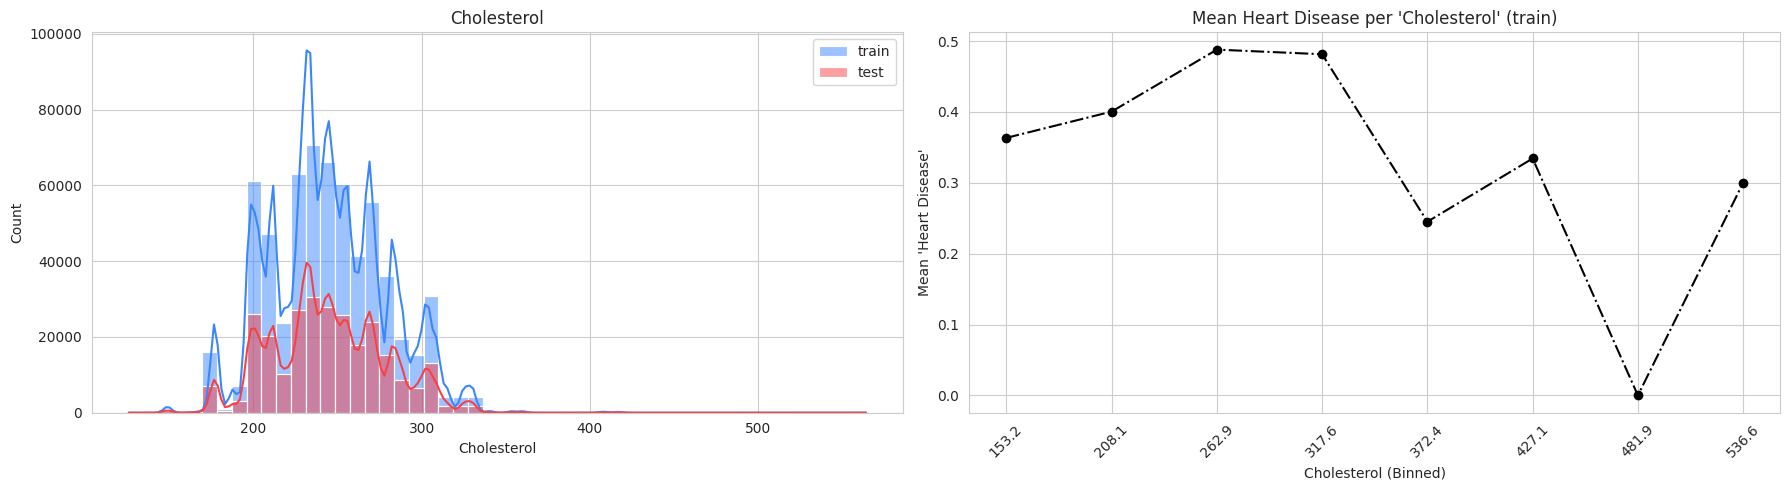

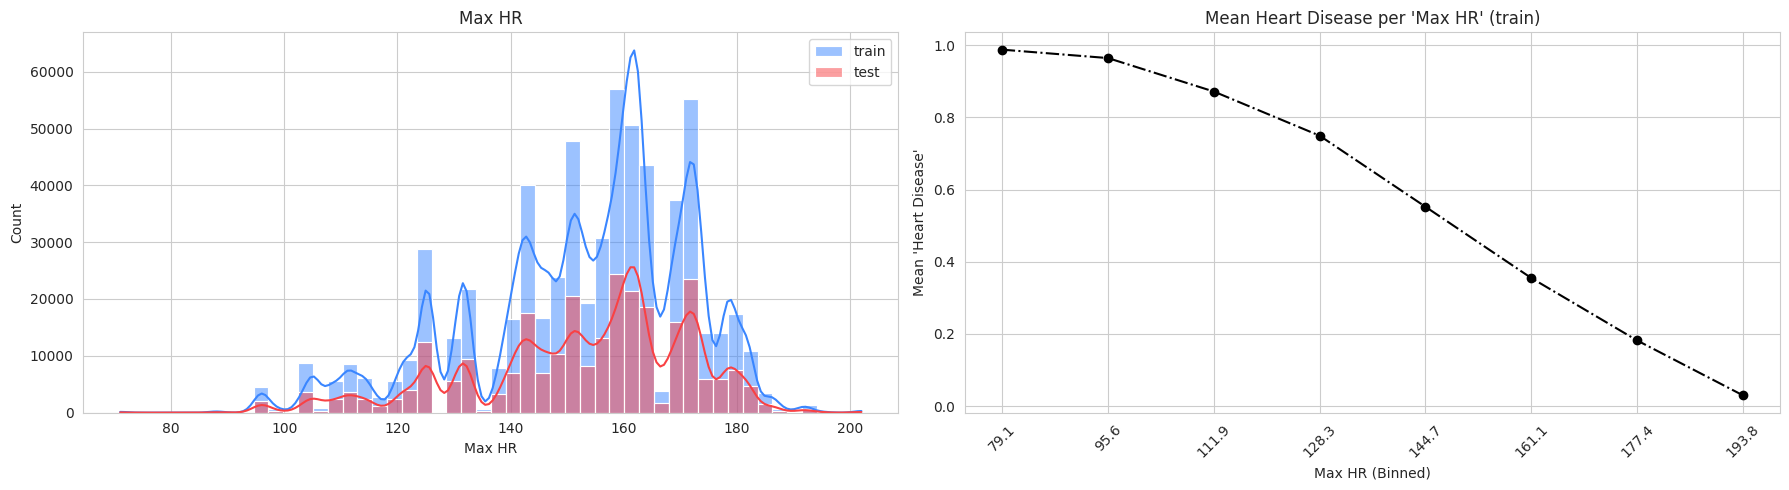

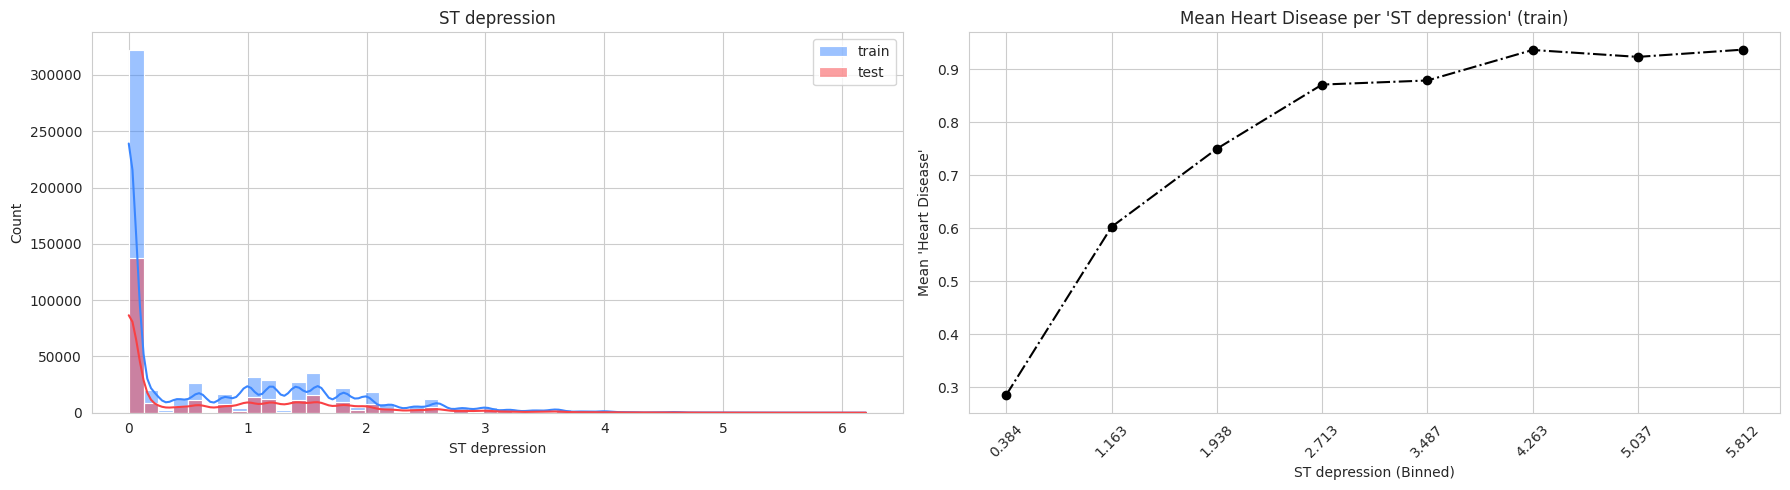

In [20]:
BINS = 8

for c in NUMS:
    # PLOT TRAIN DISTRIBUTION COMPARED WITH TEST DISTRIBUTION
    plt.figure(figsize=(18, 5))
    plt.subplot(121)
    sns.histplot(train[c],kde=True,bins=50,label='train',)
    sns.histplot(test[c],kde=True,bins=50,label='test',)
    plt.legend()
    plt.title(f"{c}")
    # PLOT TARGET RELATIONSHIP WITH BINNED BASE
    plt.subplot(122)
    train['bucket'], edges = pd.cut(train[c],bins=BINS,include_lowest=True,retbins=True,labels=False)
    bucket_means = train.groupby('bucket')[TARGET].mean()
    bin_midpoints = (edges[:-1] + edges[1:]) / 2
    plt.plot(bin_midpoints, bucket_means, marker='o',linestyle='-.',color='k')
    plt.xlabel(f'{c} (Binned)')
    plt.ylabel(f"Mean '{TARGET}'")
    plt.title(f"Mean {TARGET} per '{c}' (train)")
    plt.xticks(bin_midpoints, rotation=45)

    plt.tight_layout()
    plt.show()

train.drop(['bucket'], axis=1, inplace=True)

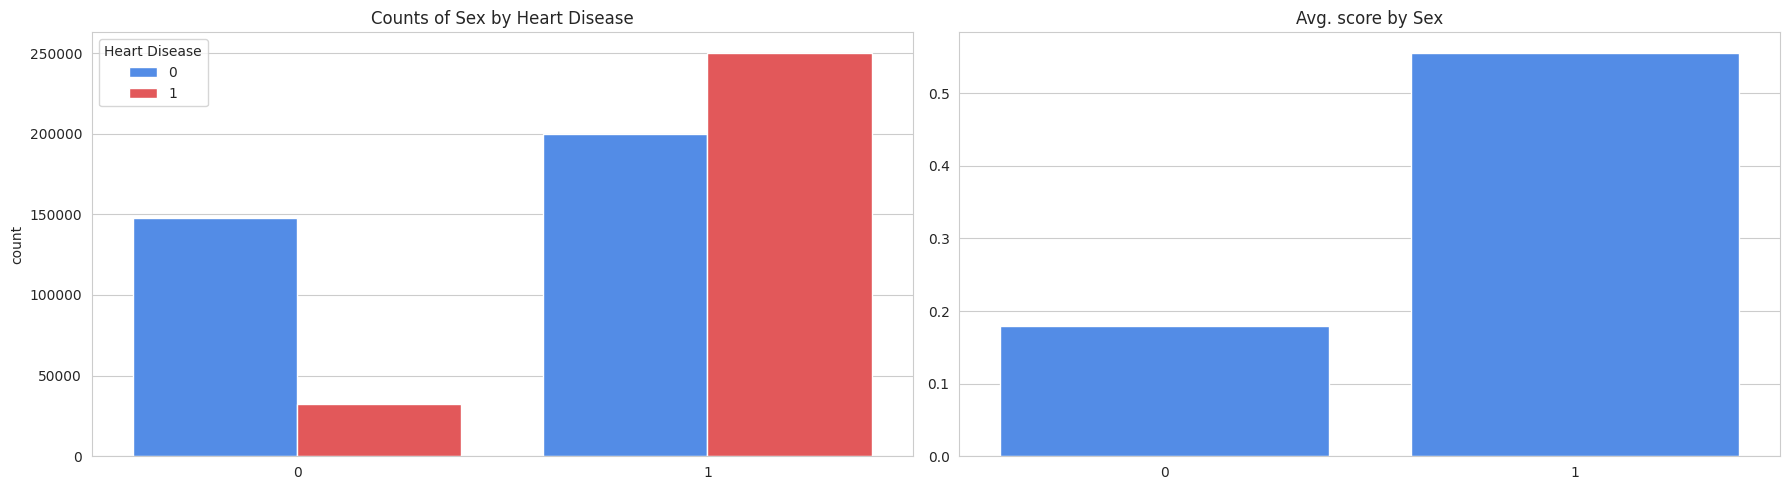

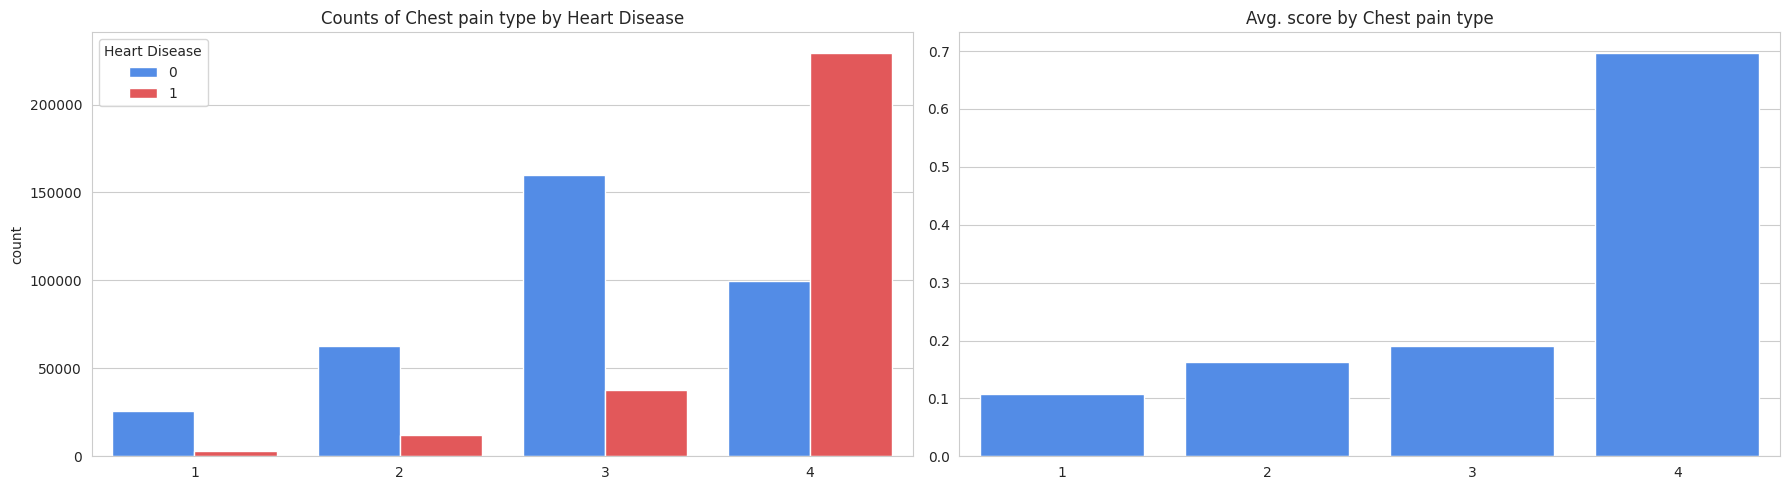

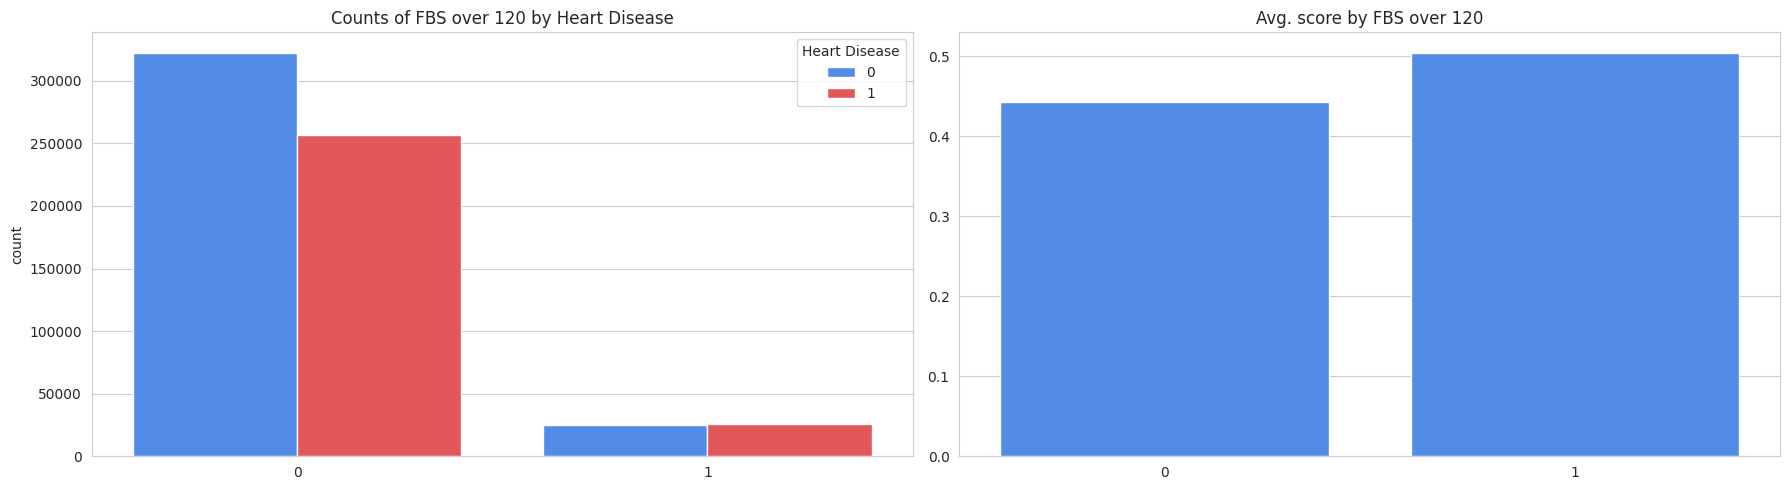

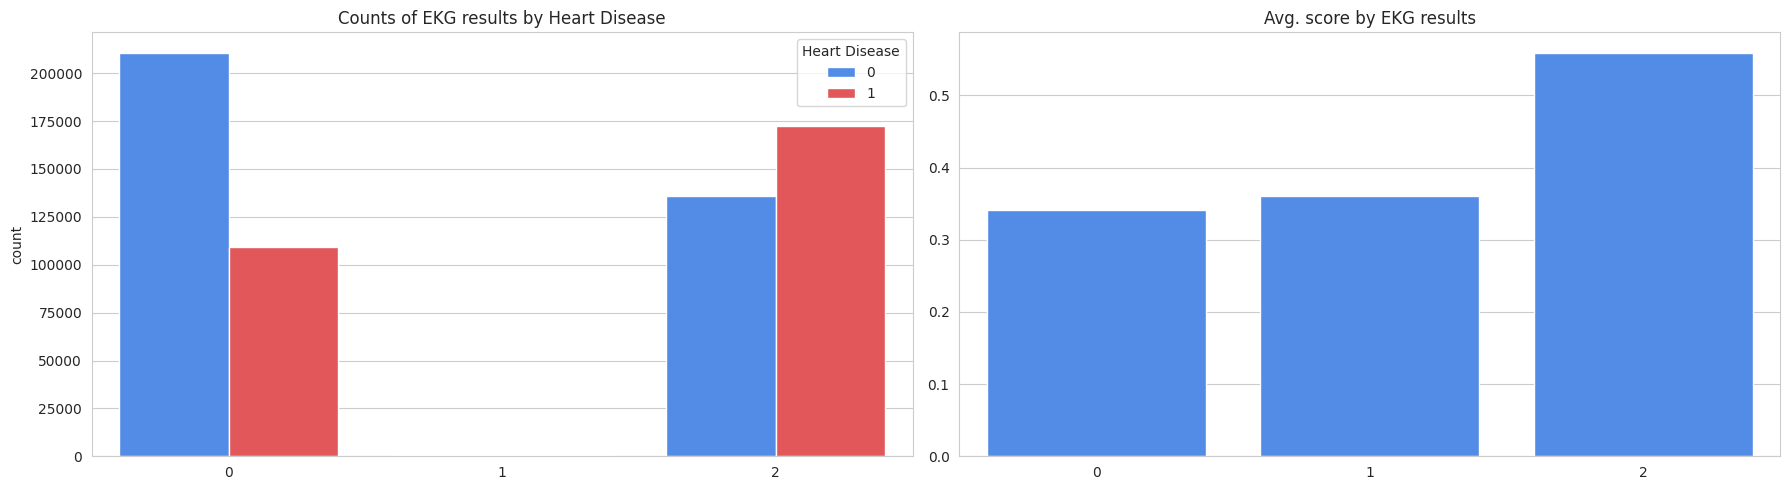

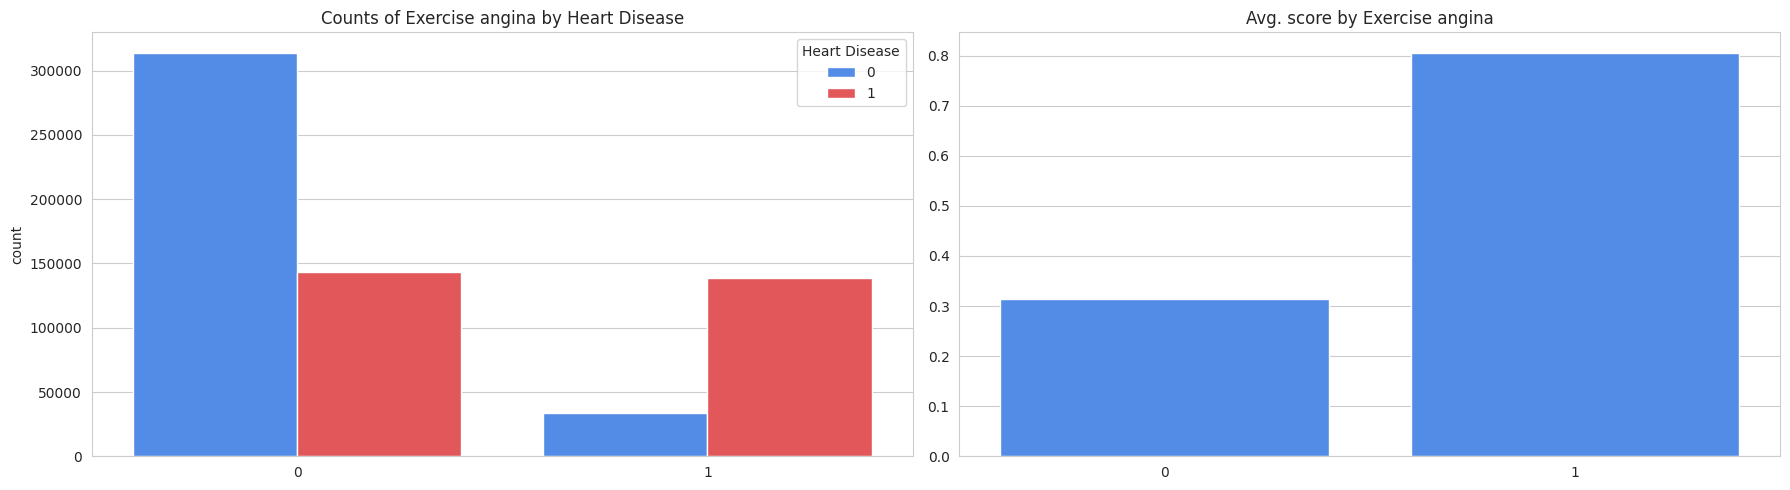

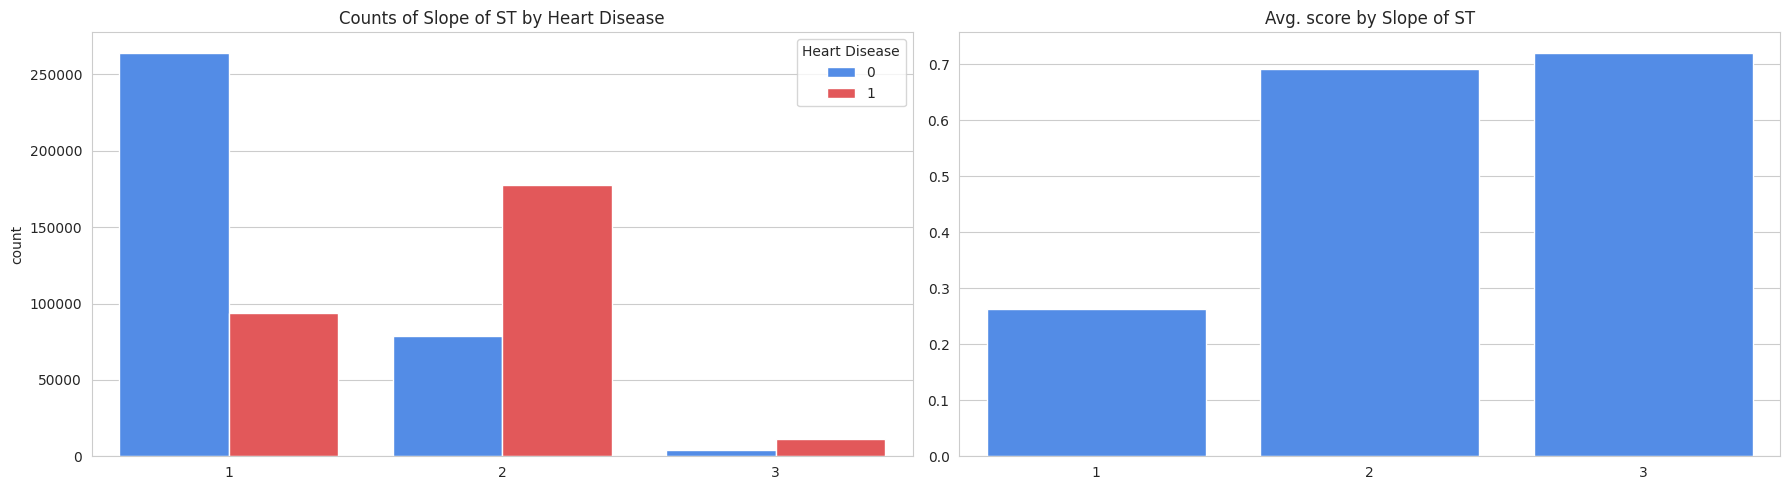

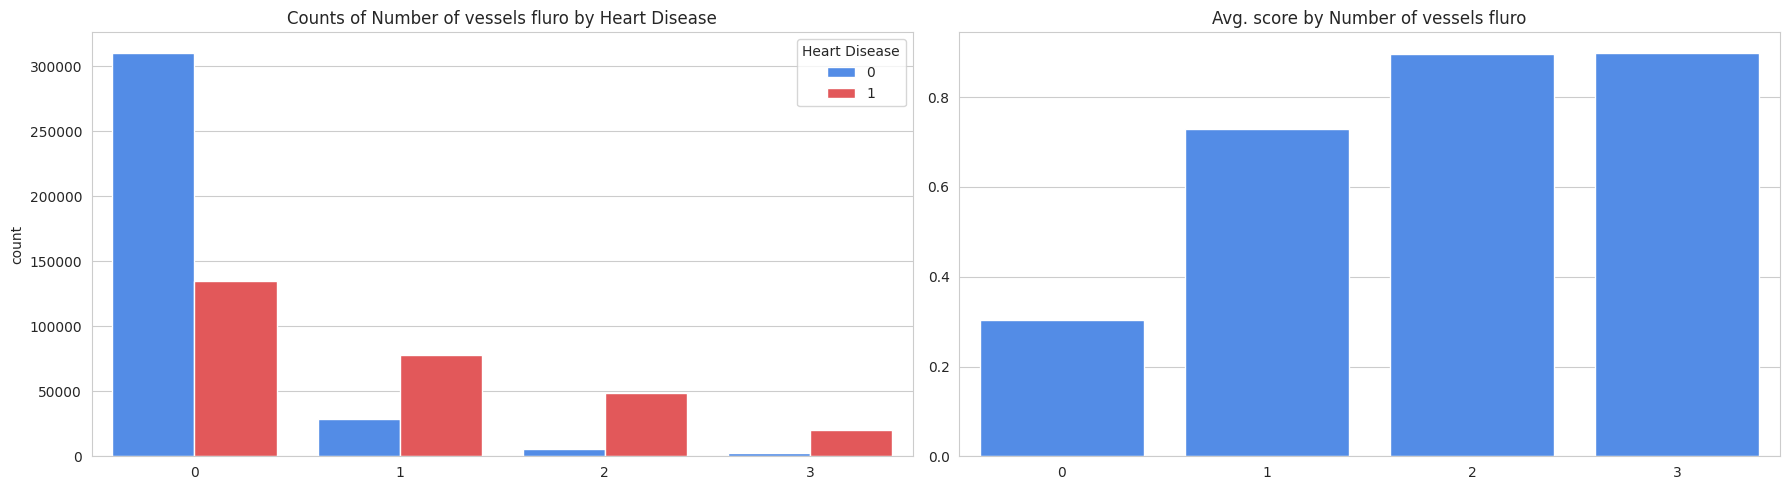

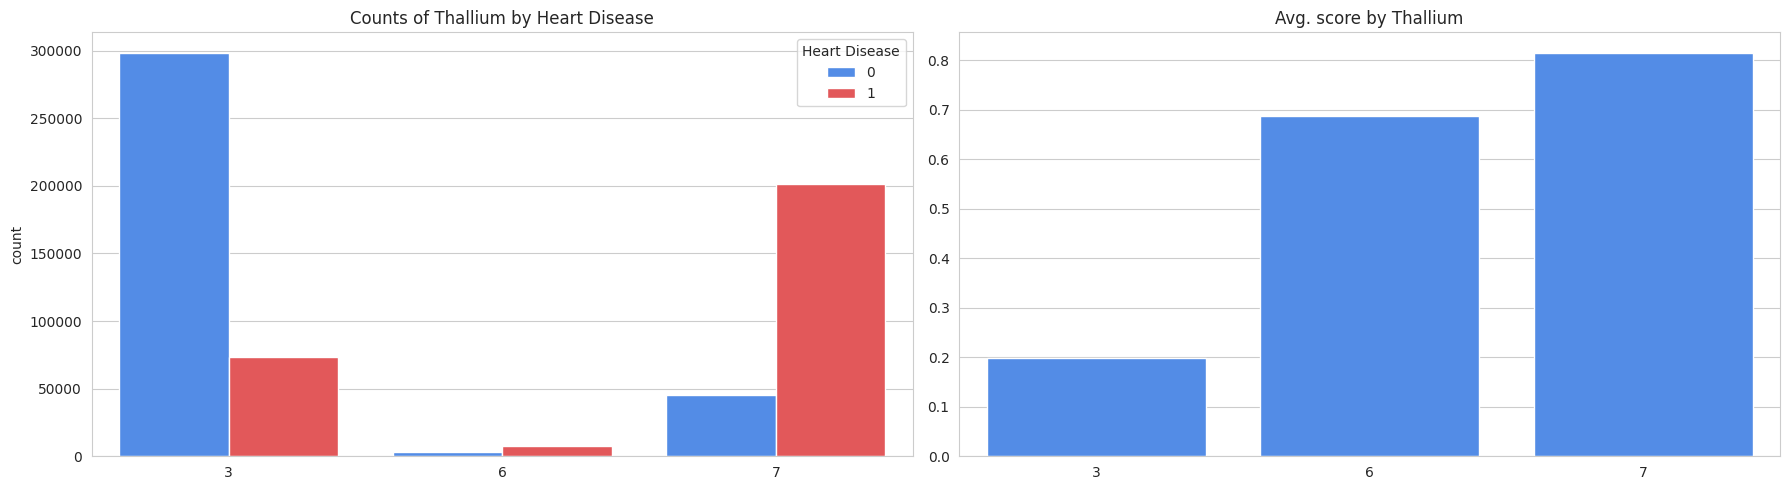

In [21]:
## -- Categorical Features: Counts and Mean by TARGET --
for i, c in enumerate(CATS):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(121)
    sns.countplot(train, x=c, hue=TARGET)
    plt.title(f"Counts of {c} by {TARGET}")
    plt.xlabel('')
    
    plt.subplot(122)
    v_mean = train.groupby(c)[TARGET].mean().sort_values(ascending=False)
    sns.barplot(x=v_mean.index, y=v_mean.values)
    plt.title(f"Avg. score by {c}")
    plt.xlabel('')
    
    plt.tight_layout()
    plt.show()

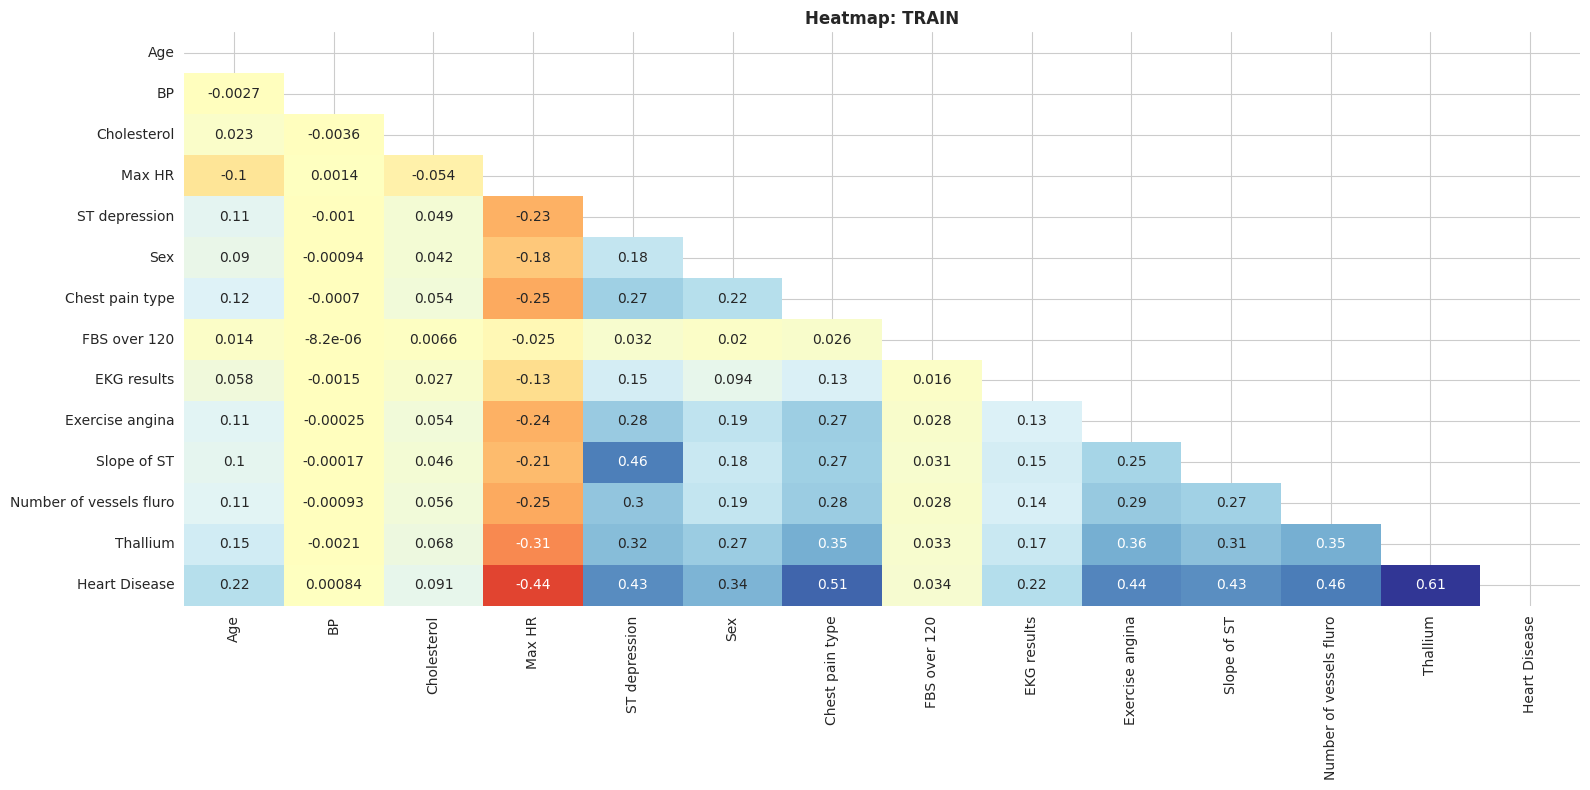

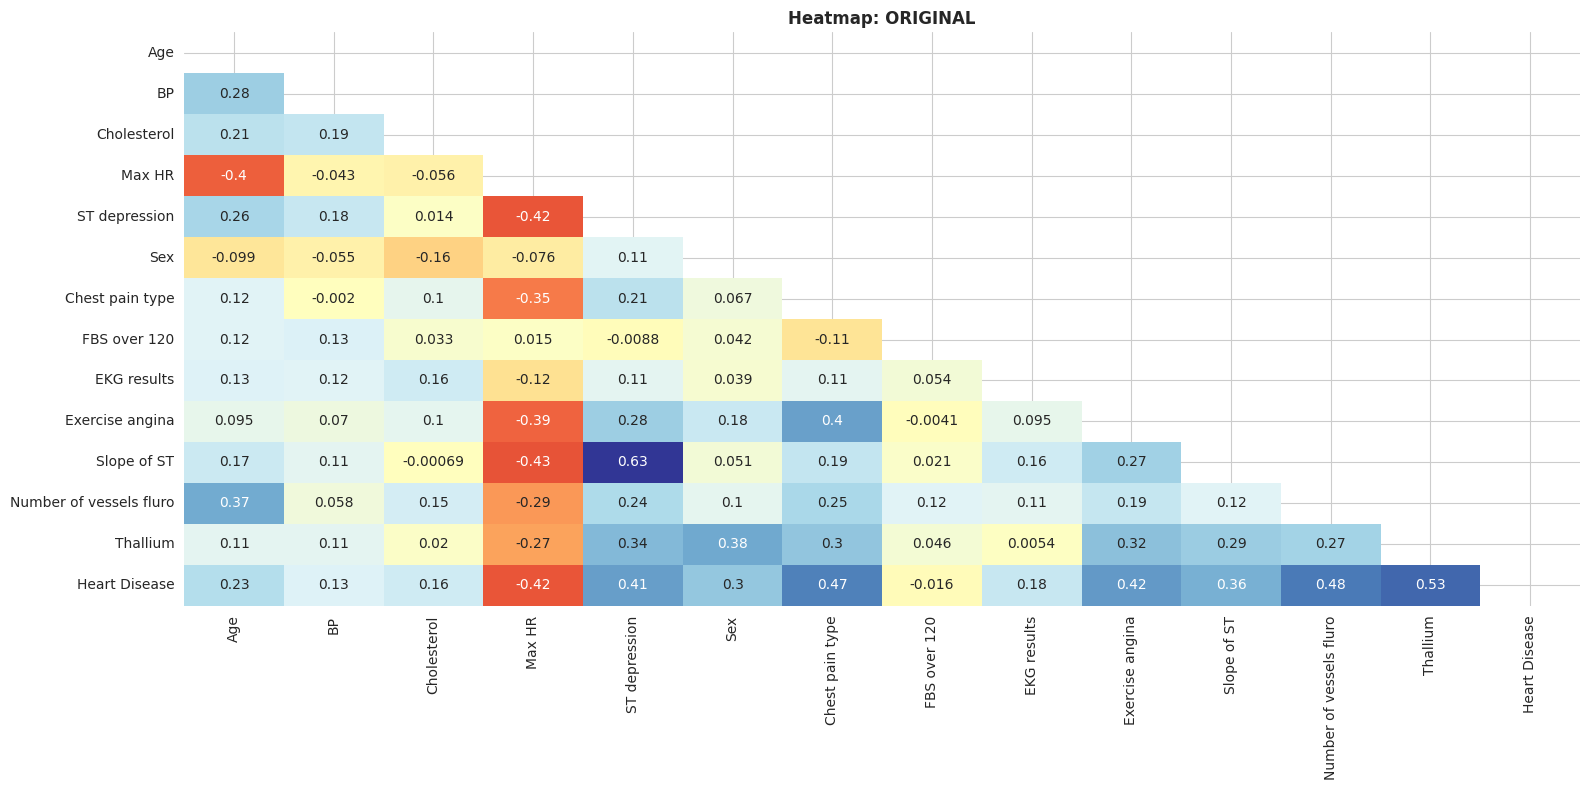

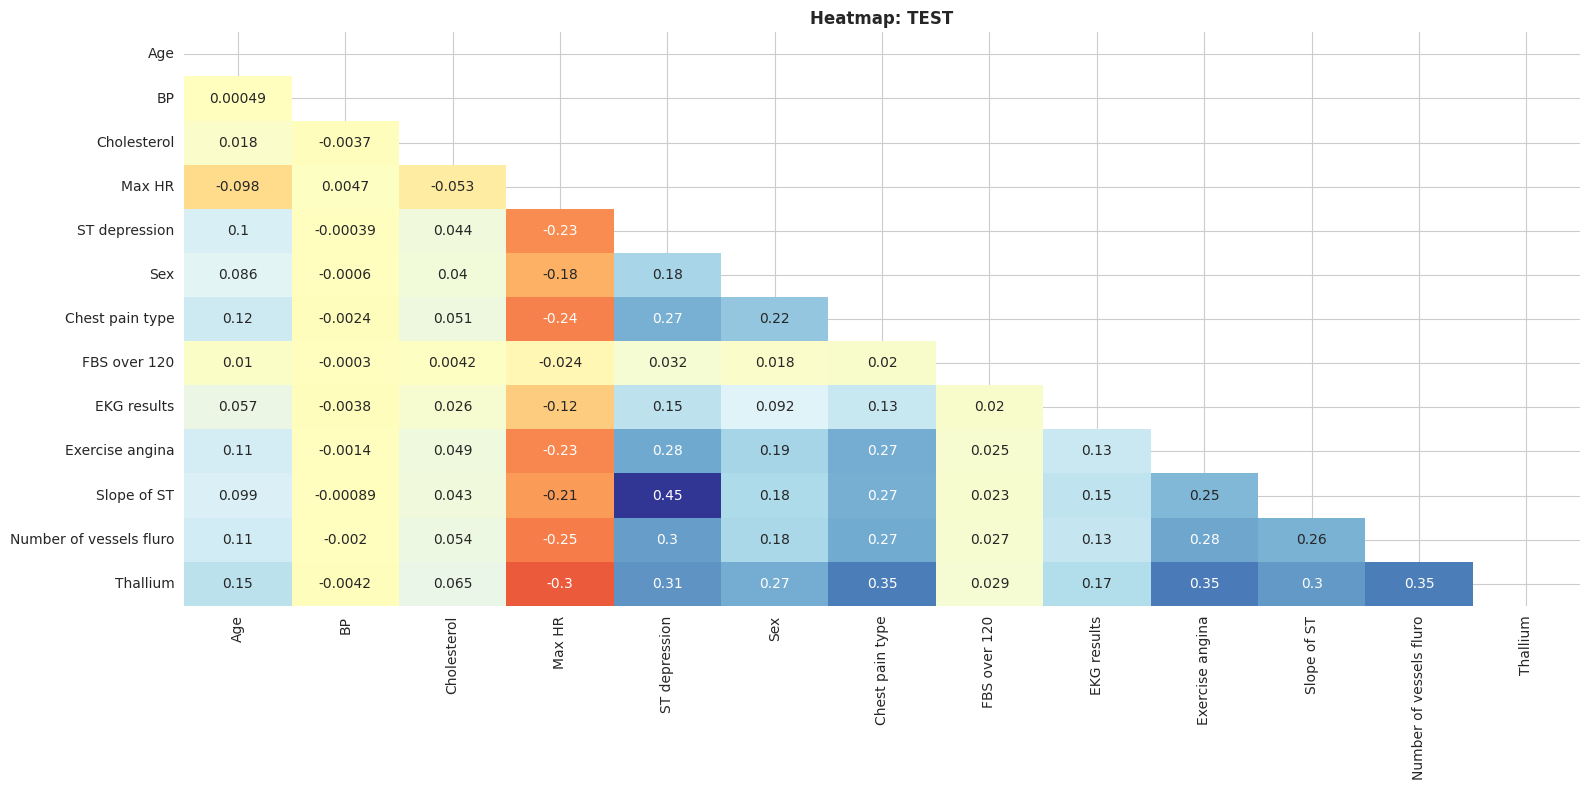

In [22]:
def plot_heatmap(data, cat_features, name='Data'):
    df = data.copy()
    for c in cat_features:
        if df[c].dtype in ['object', 'category']:
            df[c] = pd.factorize(df[c])[0]
    CORR = df.corr('spearman')
    plt.figure(figsize=(16, 8))
    sns.heatmap(CORR, mask=np.triu(CORR), annot=True, cmap='RdYlBu', cbar=False, center=0)
    plt.title(f"Heatmap: {name}", fontdict={'size':12, 'weight': 'semibold'})
    plt.tight_layout()
    plt.show()

    del df

plot_heatmap(train[BASE+[TARGET]], CATS, 'TRAIN')
plot_heatmap(orig[BASE+[TARGET]], CATS, 'ORIGINAL')
plot_heatmap(test[BASE], CATS, 'TEST')

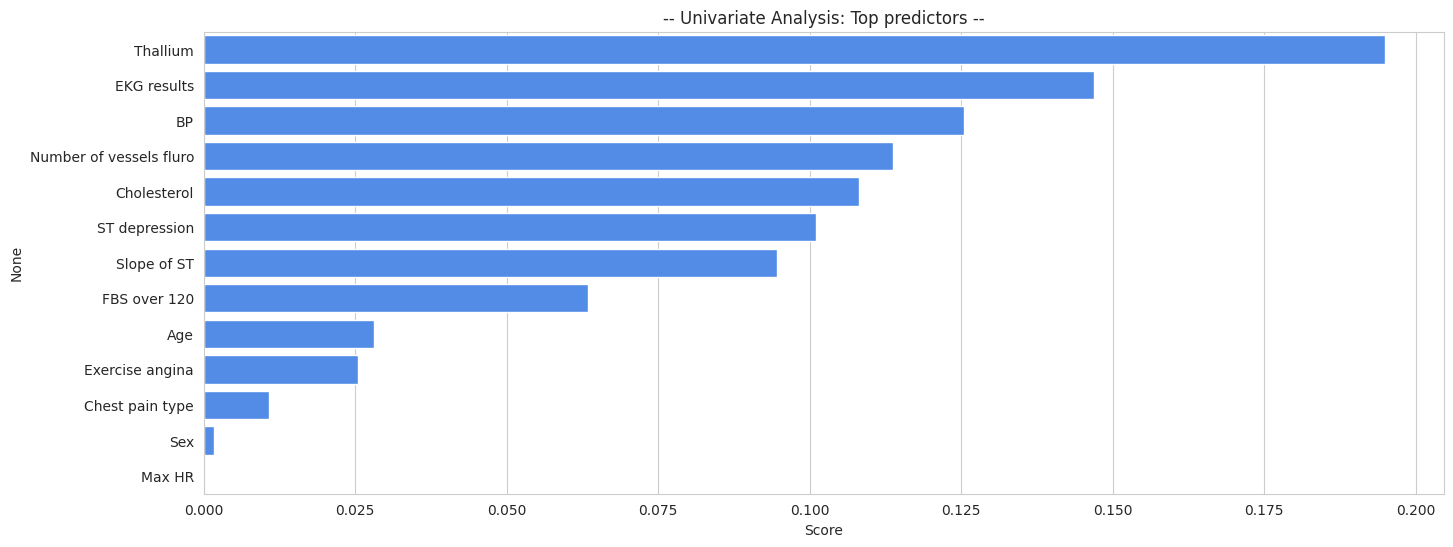

CPU times: user 50.6 s, sys: 56.8 ms, total: 50.6 s
Wall time: 50.6 s


In [23]:
%%time

## -- Mutual Info: Features relationship with Target --
mutual_info = mutual_info_regression(train[BASE], train[TARGET])
mutual_info_df = pd.DataFrame.from_dict(
    dict(zip(test.columns.tolist(), list(mutual_info))),
    orient='index', columns=['Score'],
).sort_values(by='Score', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(data=mutual_info_df, x='Score', y=mutual_info_df.index)
plt.title('-- Univariate Analysis: Top predictors --')
plt.show()

## 1. Kolmogorov-Smirnov (K-S) test

feature             	ks-stat 	drift
--------------------	------- 	-------


Age                 	0.0022  	✅ Safe!
BP                  	0.0023  	✅ Safe!
Cholesterol         	0.0014  	✅ Safe!
Max HR              	0.0017  	✅ Safe!
ST depression       	0.0026  	✅ Safe!


Sex                 	0.0016  	✅ Safe!
Chest pain type     	0.0021  	✅ Safe!


FBS over 120        	0.0001  	✅ Safe!
EKG results         	0.0016  	✅ Safe!
Exercise angina     	0.0009  	✅ Safe!
Slope of ST         	0.0031  	✅ Safe!
Number of vessels fluro	0.0022  	✅ Safe!
Thallium            	0.0003  	✅ Safe!



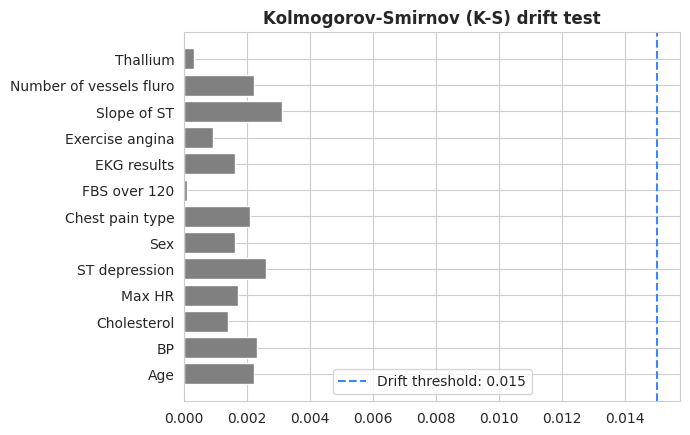

In [24]:
from scipy.stats import ks_2samp

def k_s_drift_test(train, test, features):
    df_train = train.copy()
    df_test  = test.copy()

    ks_stats_all = []
    cols = []
    threshold = 0.015

    print(f"{'feature':<20}\t{'ks-stat':<8}\t{'drift'}")
    print(f"{'-'*20:<20}\t{'-------':<8}\t{'-------'}")
    
    for c in features:
        ks_stat, p_val = np.round(ks_2samp(df_train[c].values, df_test[c].values), 4)
        if ks_stat >= threshold:
            print(f"{COLOR}{c:<20}\t{ks_stat:<8}\t❌ Drift{RESET}")
        else:
            print(f"{c:<20}\t{ks_stat:<8}\t✅ Safe!")

        ks_stats_all.append(ks_stat)
        cols.append(c)

    print()
    plt.barh(cols, ks_stats_all, color=['r' if c >= threshold else 'gray'for c in ks_stats_all])
    plt.axvline(x=threshold, linestyle='--', label=f'Drift threshold: {threshold}')
    plt.title('Kolmogorov-Smirnov (K-S) drift test', fontweight='semibold')
    plt.legend()
    plt.show()

    gc.collect()

## -- Execute function --
k_s_drift_test(train, test, BASE)

# ML TRAINING

In [25]:
FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('📥 Total Features:', len(FEATURES))

X = train[FEATURES]
y = train[TARGET].values

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

oof_final    = pd.DataFrame()
test_final   = pd.DataFrame()
model_scores = pd.Series()

📥 Total Features: 13


## ~ TREE MODELS

In [26]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [27]:
## -- Define Models --
tree_models = {
    'xgb': xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=SEED,
        enable_categorical=True,
        n_jobs=os.cpu_count(),
        verbosity=0,
        device='cuda' if torch.cuda.is_available() else 'cpu',
    ),
    'lgb': lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        random_state=SEED,
        nthreads=os.cpu_count(),
        verbose=-1,
        device='gpu' if torch.cuda.is_available() else 'cpu',
    ),
    'cat': cgb.CatBoostClassifier(
        loss_function='Logloss', # -> also 'CrossEntropy'
        eval_metric='AUC',
        random_state=SEED,
        allow_writing_files=False,
        cat_features=CATS,
        verbose=0,
        thread_count=os.cpu_count(),
        task_type='GPU' if torch.cuda.is_available() else 'CPU',
    ),
    'rfc': RandomForestClassifier(
        # n_estimators=20,
        # max_depth=5,
        n_jobs=os.cpu_count(),
        random_state=SEED,
    ),
    'hst': HistGradientBoostingClassifier(
        tol=1e-5,
        random_state=SEED,
    ),
}

print(f"Tree Models to train: {len(tree_models)} -> ", end="")
print(list(tree_models.keys()))

Tree Models to train: 5 -> ['xgb', 'lgb', 'cat', 'rfc', 'hst']


Training Models.:   0%|          | 0/5 [00:00<?, ?it/s]


[1] xgb ████████████████████████████████████████


	Fold 1/5 AUC: 0.95463


	Fold 2/5 AUC: 0.95480


	Fold 3/5 AUC: 0.95549


	Fold 4/5 AUC: 0.95426


	Fold 5/5 AUC: 0.95445
|------------------------------
| OOF AUC: 0.95473
| AVG AUC: 0.95473 ± 0.00042
|------------------------------
Time: 3.79 secs


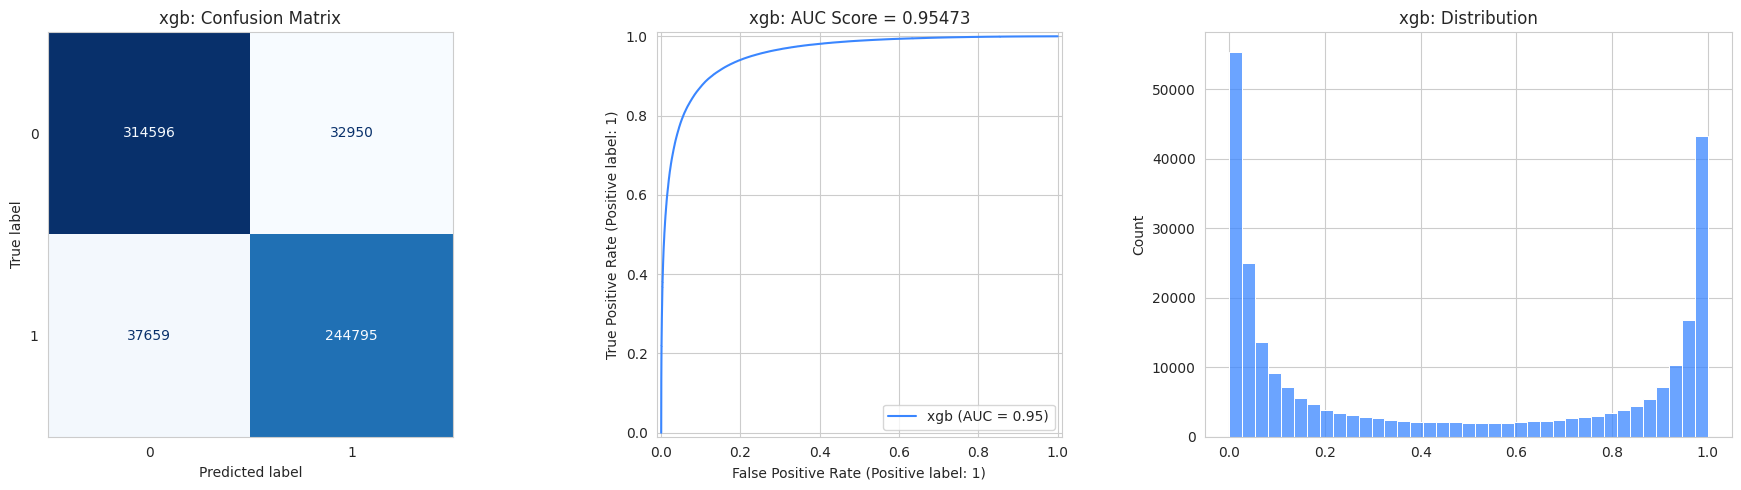


[2] lgb ████████████████████████████████████████


	Fold 1/5 AUC: 0.95466


	Fold 2/5 AUC: 0.95491


	Fold 3/5 AUC: 0.95542


	Fold 4/5 AUC: 0.95421


	Fold 5/5 AUC: 0.95461
|------------------------------
| OOF AUC: 0.95476
| AVG AUC: 0.95476 ± 0.00040
|------------------------------
Time: 7.75 secs


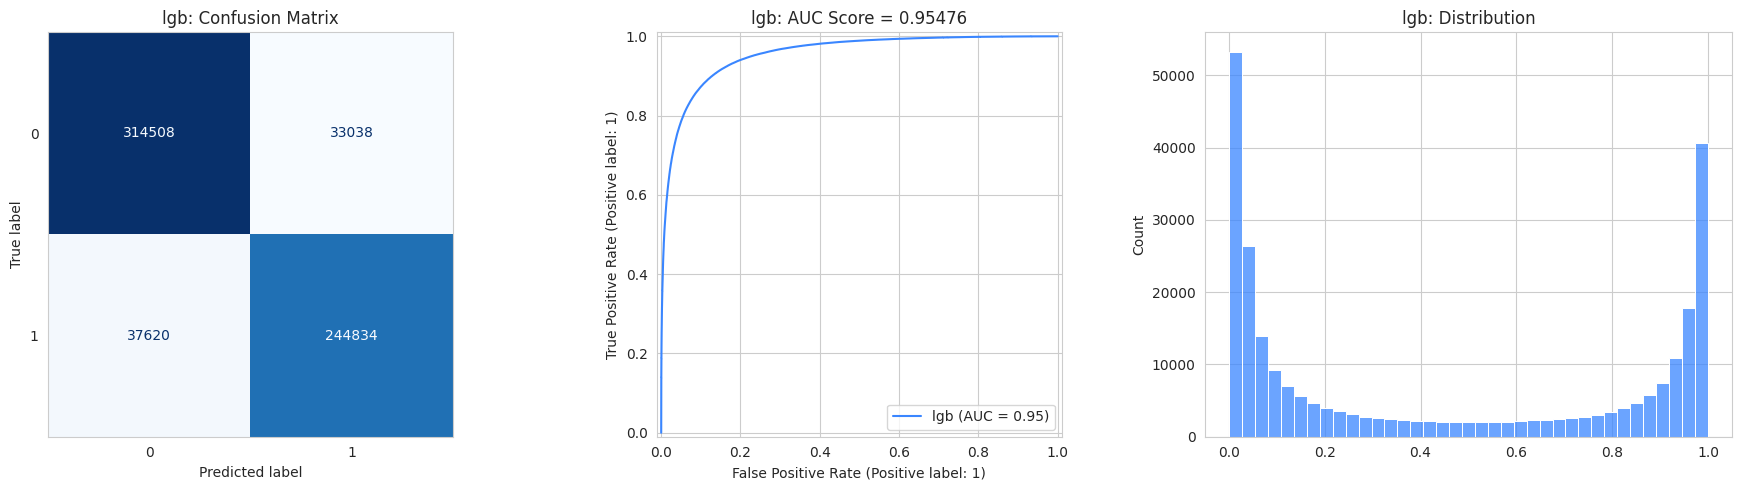


[3] cat ████████████████████████████████████████


	Fold 1/5 AUC: 0.95520


	Fold 2/5 AUC: 0.95542


	Fold 3/5 AUC: 0.95601


	Fold 4/5 AUC: 0.95483


	Fold 5/5 AUC: 0.95512
|------------------------------
| OOF AUC: 0.95531
| AVG AUC: 0.95531 ± 0.00040
|------------------------------
Time: 333.47 secs


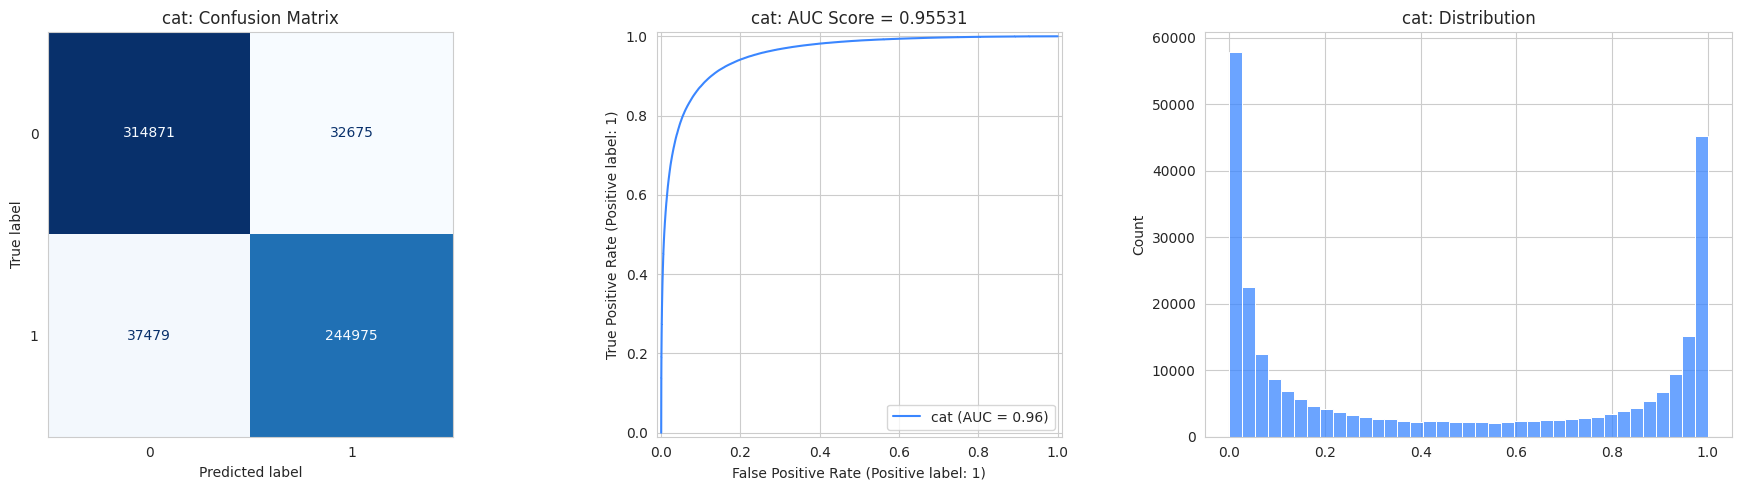


[4] rfc ████████████████████████████████████████


	Fold 1/5 AUC: 0.94684


	Fold 2/5 AUC: 0.94711


	Fold 3/5 AUC: 0.94749


	Fold 4/5 AUC: 0.94637


	Fold 5/5 AUC: 0.94688


|------------------------------
| OOF AUC: 0.94694
| AVG AUC: 0.94694 ± 0.00036
|------------------------------
Time: 11.19 secs


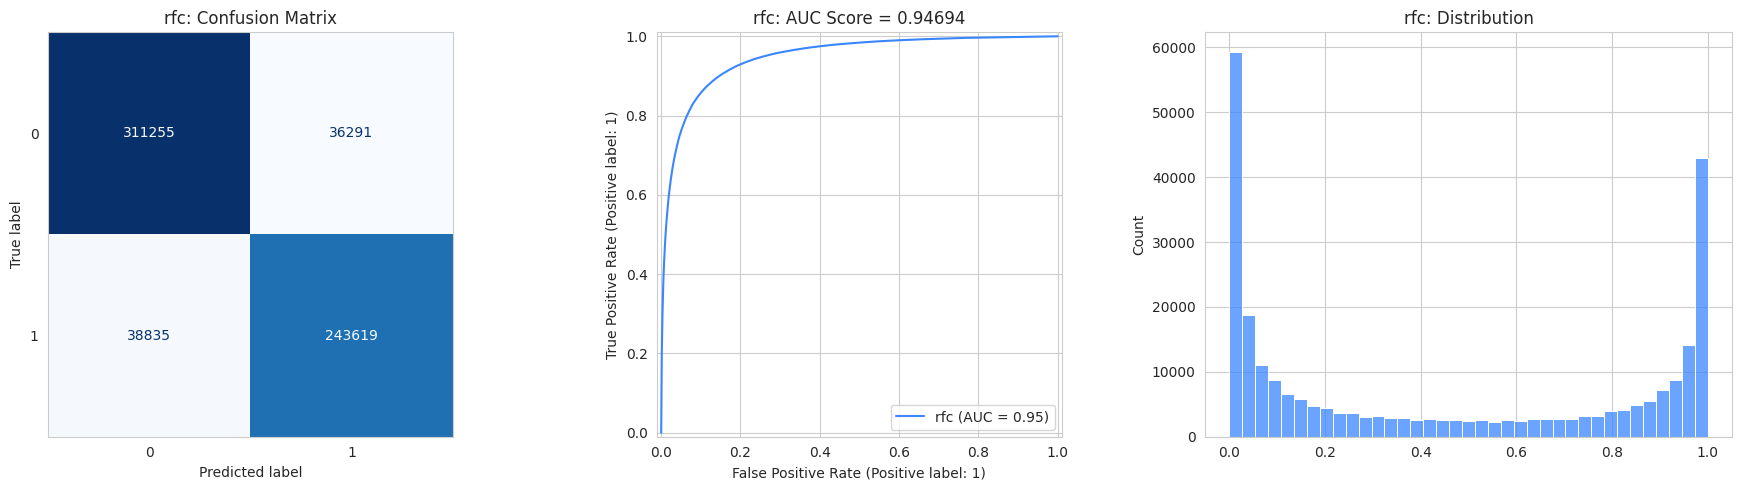


[5] hst ████████████████████████████████████████


	Fold 1/5 AUC: 0.95465


	Fold 2/5 AUC: 0.95488


	Fold 3/5 AUC: 0.95543


	Fold 4/5 AUC: 0.95423


	Fold 5/5 AUC: 0.95454


|------------------------------
| OOF AUC: 0.95474
| AVG AUC: 0.95475 ± 0.00040
|------------------------------
Time: 11.84 secs


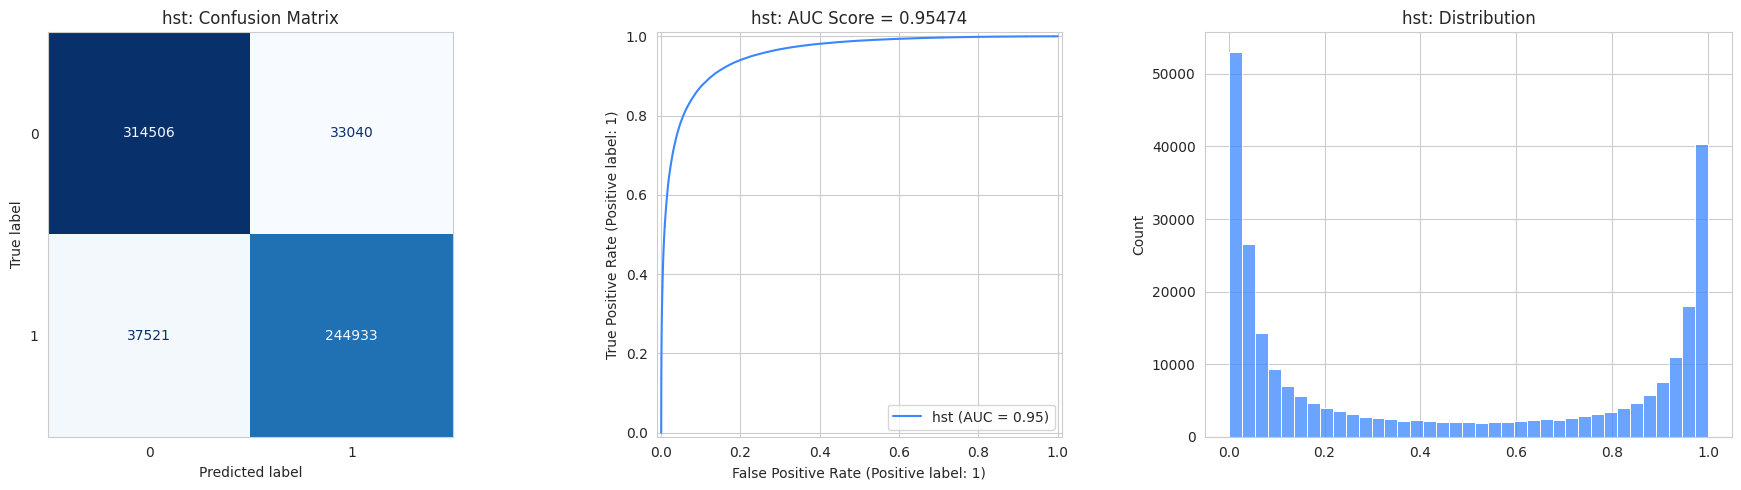

In [28]:
## -- Initiate GBDTs Training -- 
TREE_MODELS = {}

for i, (name, model) in tqdm(
    enumerate(tree_models.items()),
    total=len(tree_models),
    desc='Training Models.'
):
    print(f"\n[{i+1}] {COLOR}{name} {'█'*40}{RESET}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_AUCs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        X_test = test[FEATURES].copy()

        ## -- Concatenate original data --
        X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        combine = pd.concat([X_train, X_val, X_test])
        for c in CATS:
            combine[c] = combine[c].astype('category')
            
        X_train = combine.iloc[:len(X_train)]
        X_val   = combine.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combine.iloc[len(X_train)+len(X_val):]

        model.fit(X_train, y_train)
        oof_preds[val_idx] = model.predict_proba(X_val)[:,1]

        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_AUCs.append(fold_auc)
        print(f"\tFold {fold+1}/{kf.n_splits} AUC: {fold_auc:.5f}")

        test_preds += model.predict_proba(X_test)[:,1]


    test_preds /= kf.n_splits
    
    tok = time()
    tiktok = tok-tik
    
    ## -- After all folds --
    overall_AUC = np.round(roc_auc_score(y, oof_preds), 5)
    print(f"|{'-'*30}")
    print(f"| OOF AUC: {overall_AUC}")
    print(f"| AVG AUC: {np.mean(fold_AUCs):.5f} ± {np.std(fold_AUCs):.5f}")
    print(f"|{'-'*30}")
    print(f"Time: {tiktok:.2f} secs")
    
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]
    # Right: Confusion matrix (threshold = 0.5)
    pred_labels = (oof_preds >= 0.5).astype('int8')
    ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    axs[0].set_title(f"{name}: Confusion Matrix")
    axs[0].grid(False)
    
    # Left: ROC curve
    RocCurveDisplay.from_predictions(y, oof_preds, name=name, ax=axs[1])
    axs[1].set_title(f"{name}: AUC Score = {overall_AUC}")
    # axs[1].grid(False)

    sns.histplot(test_preds, ax=axs[2])
    axs[2].set_title(f"{name}: Distribution")
    
    plt.tight_layout()
    plt.show()
    
    n = name + str(overall_AUC).split('.')[1]
    oof_final[n]    = oof_preds
    test_final[n]   = test_preds
    TREE_MODELS[n]  = model
    model_scores[n] = overall_AUC
    
    gc.collect()

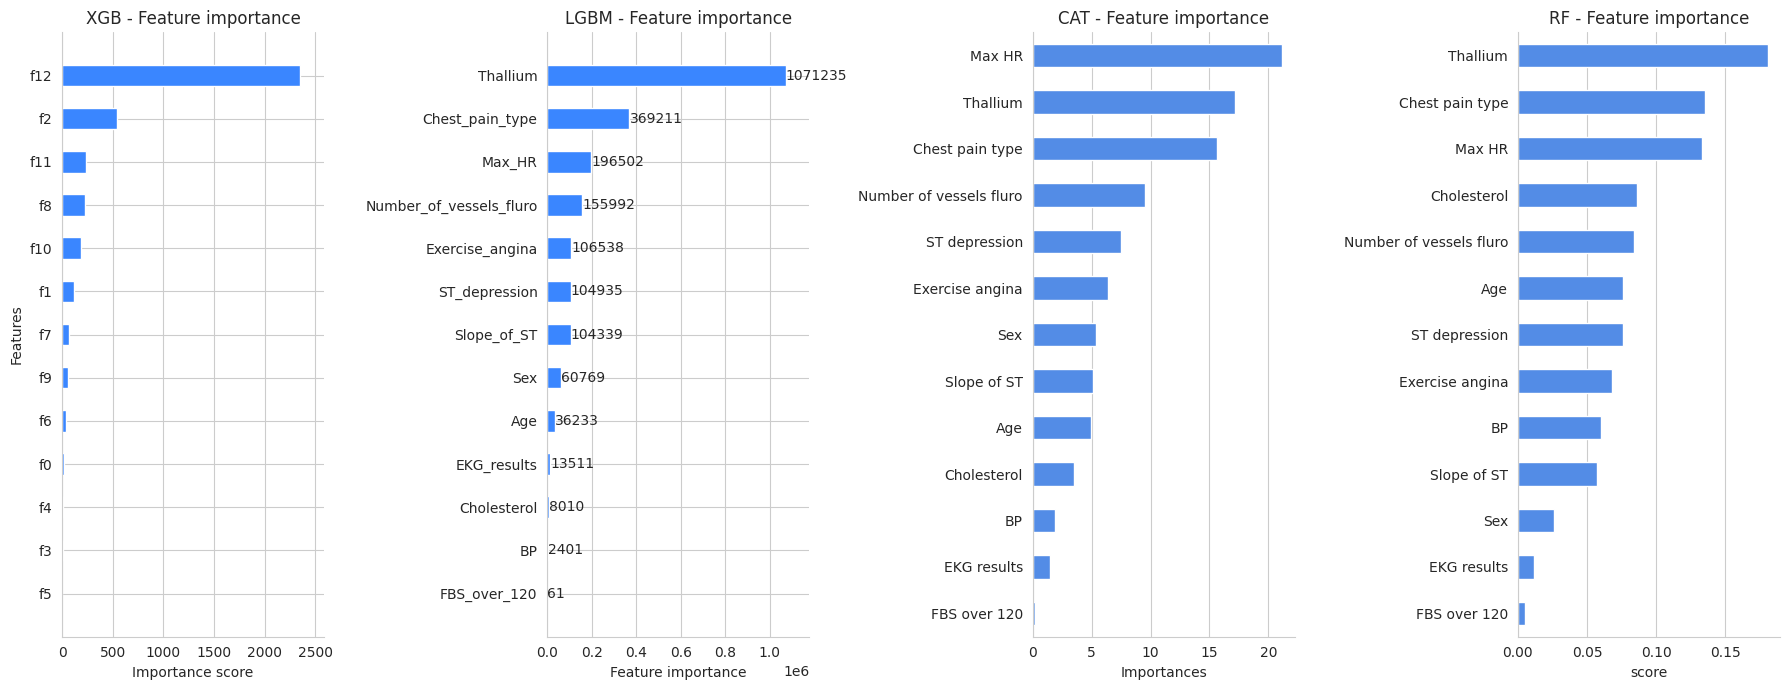

In [29]:
## -- Plot Feature Importances -- 
fig, axs = plt.subplots(1, 4, figsize=(18, 7))

## -- XGBoost --
for k, v in TREE_MODELS.items():
    if 'xgb' in k:
        xgb.plot_importance(
            v,
            importance_type='gain',
            title='XGB - Feature importance',
            height=0.5, show_values=False, ax=axs[0], # grid=False,
        )

    ## -- LightGBM -- 
    elif 'lgb' in k:
        lgb.plot_importance(
            v,
            importance_type='gain',
            title='LGBM - Feature importance',
            height=0.5, precision=0, ax=axs[1], # grid=False,
        )
        axs[1].set_ylabel('')
    
    ## -- CatBoost -- 
    elif 'cat' in k:
        cat_imp_df = v.get_feature_importance(prettified=True)
        sns.barplot(data=cat_imp_df, x='Importances', y='Feature Id', width=0.5, ax=axs[2])
        axs[2].set_title('CAT - Feature importance')
        axs[2].set_ylabel('')
    
    ## -- RandomForest -- 
    elif 'rfc' in k:
        rf_dicts = dict(zip(X_train.columns, v.feature_importances_))
        rf_imp_df = pd.DataFrame.from_dict(rf_dicts, orient='index', columns=['score'])\
                                .sort_values('score', ascending=False)
        sns.barplot(rf_imp_df, x=rf_imp_df.score, y=rf_imp_df.index, width=0.5, ax=axs[3])
        axs[3].set_title('RF - Feature importance')
        axs[3].set_ylabel('')
    
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.show()

In [30]:
TREE_MODELS

{'xgb95473': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device='cpu', early_stopping_rounds=None,
               enable_categorical=True, eval_metric='auc', feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=224, num_parallel_tree=None, ...),
 'lgb95476': LGBMClassifier(device='cpu', metric='auc', nthreads=224, objective='binary',
                random_state=42, verbose=-1),
 'cat95531': <catboost.core.CatBoostClassifier at 0x79f1cda7b0b0>,
 'rfc94694':

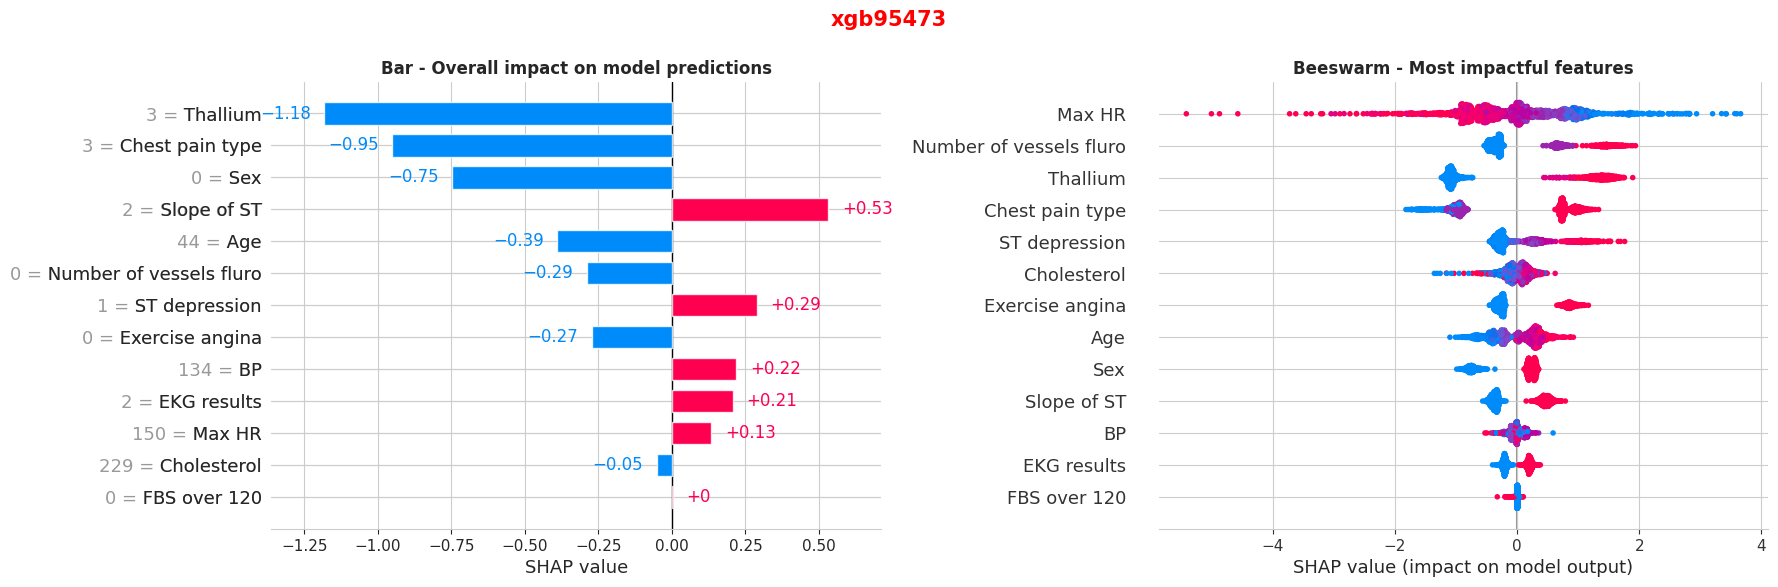

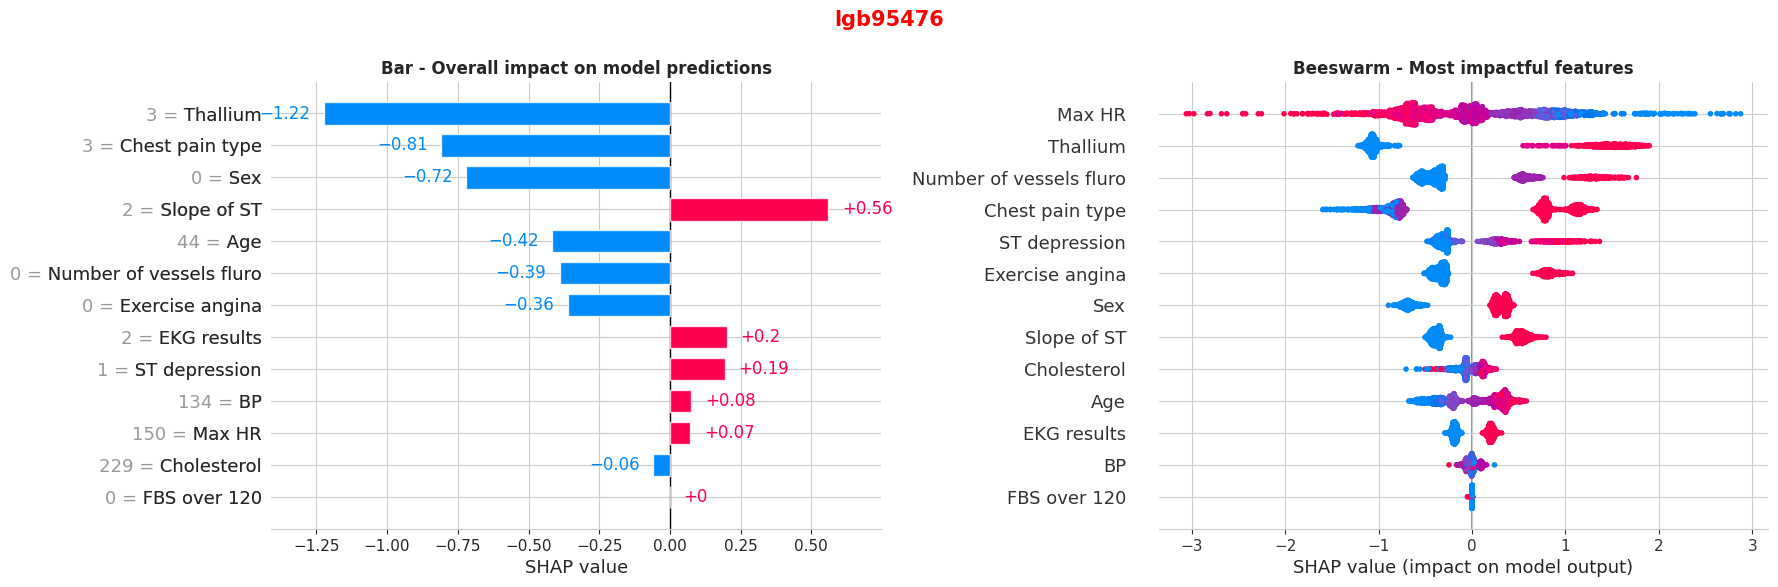

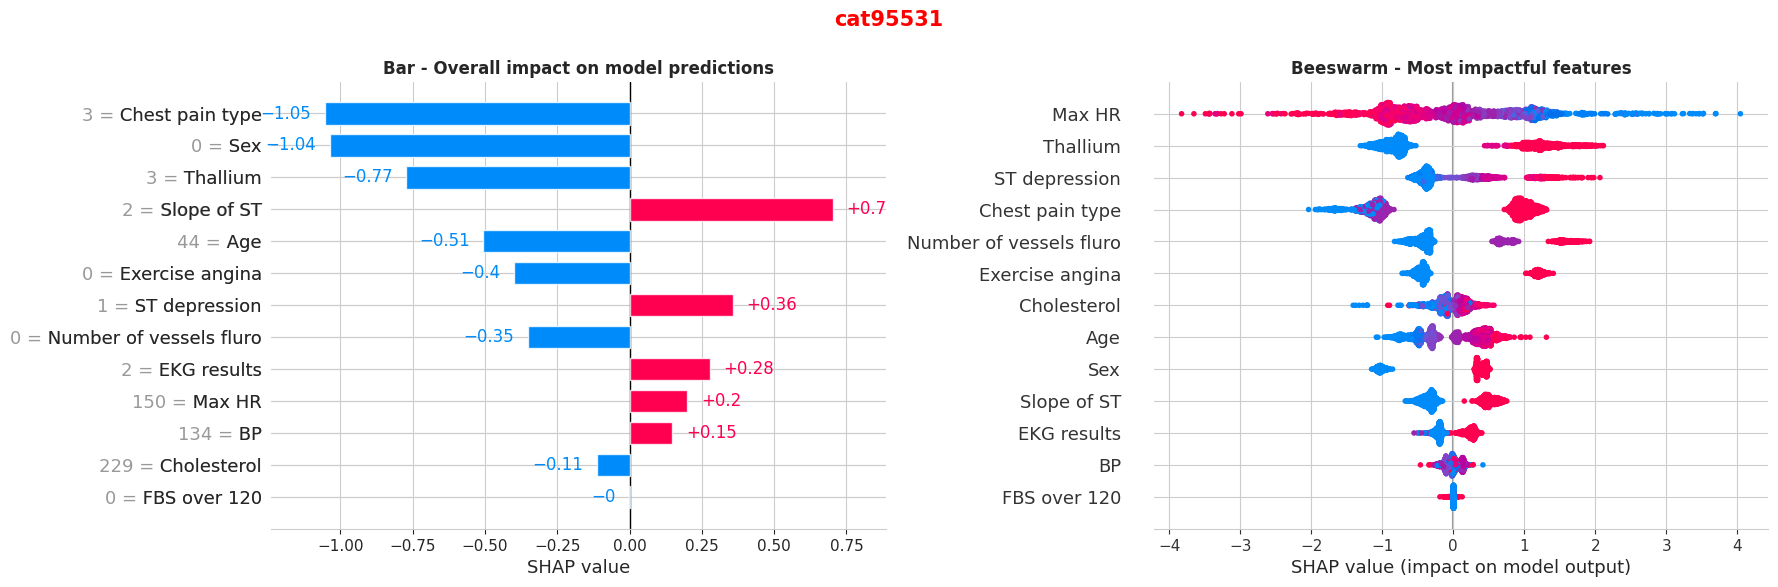

In [31]:
## -- Plot SHAP values --
MAX = 15

for i, (name, model) in enumerate(TREE_MODELS.items()):
    if 'xgb' in name or 'lgb' in name or 'cat' in name:
        explainer = shap.TreeExplainer(model)
        explanation = explainer(X_val.iloc[:2000])
    
        ## -- Bar plot --
        plt.subplot(121)
        shap.plots.bar(explanation[0], max_display=MAX, show=False)
        plt.title('Bar - Overall impact on model predictions', fontweight='semibold')
    
        ## -- Beeswarm plot --
        plt.subplot(122)
        shap.plots.beeswarm(
            explanation, max_display=MAX, order=explanation.abs.max(0),
            plot_size=(18, 6), color_bar=False, show=False,
        )
    
        plt.title('Beeswarm - Most impactful features', fontweight='semibold')
        plt.suptitle(f"{name}", fontweight='bold', fontsize=15, color='r')
        plt.tight_layout(pad=1.5) 
        plt.show() 
        print()

In [32]:
display(oof_final.head())
print()
display(test_final.head())

,xgb95473,lgb95476,cat95531,rfc94694,hst95474
0,0.994386,0.994202,0.997813,1.00,0.994062
1,0.006982,0.015327,0.011032,0.00,0.014025
2,0.011057,0.017355,0.010503,0.00,0.015861
3,0.061224,0.038277,0.053103,0.04,0.034909
4,0.997556,0.995637,0.998192,1.00,0.995507


,xgb95473,lgb95476,cat95531,rfc94694,hst95474
0,0.954370,0.930644,0.955729,0.830,0.942872
1,0.008005,0.008977,0.006726,0.000,0.008849
2,0.987316,0.983156,0.989553,0.998,0.980815
3,0.007147,0.006733,0.003946,0.004,0.006455
4,0.176082,0.190565,0.200784,0.218,0.191148


## ~ LINEAR MODELS

In [33]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [34]:
## -- Define Models --
linear_models = {
    'log': LogisticRegressionCV(
        max_iter=1000,
        tol=1e-5, 
        scoring='roc_auc',
        class_weight='balanced',
        n_jobs=os.cpu_count(),
        random_state=SEED,
    ),
    'mlp': MLPClassifier(
        tol=1e-5,
        random_state=SEED,
    ),
}

print(f"Linear Models to train: {len(linear_models)} -> ", end="")
print(list(linear_models.keys()))

Linear Models to train: 2 -> ['log', 'mlp']


## ~ LINEAR MODELS 1: OHE ONLY CATS

Training Models.:   0%|          | 0/2 [00:00<?, ?it/s]


[1] log ████████████████████████████████████████


	Fold 1/5 AUC: 0.95265


	Fold 2/5 AUC: 0.95304


	Fold 3/5 AUC: 0.95348


	Fold 4/5 AUC: 0.95223


	Fold 5/5 AUC: 0.95307


|------------------------------
| OOF AUC: 0.95289
| AVG AUC: 0.95289 ± 0.00042
|------------------------------
Time: 63.73 secs


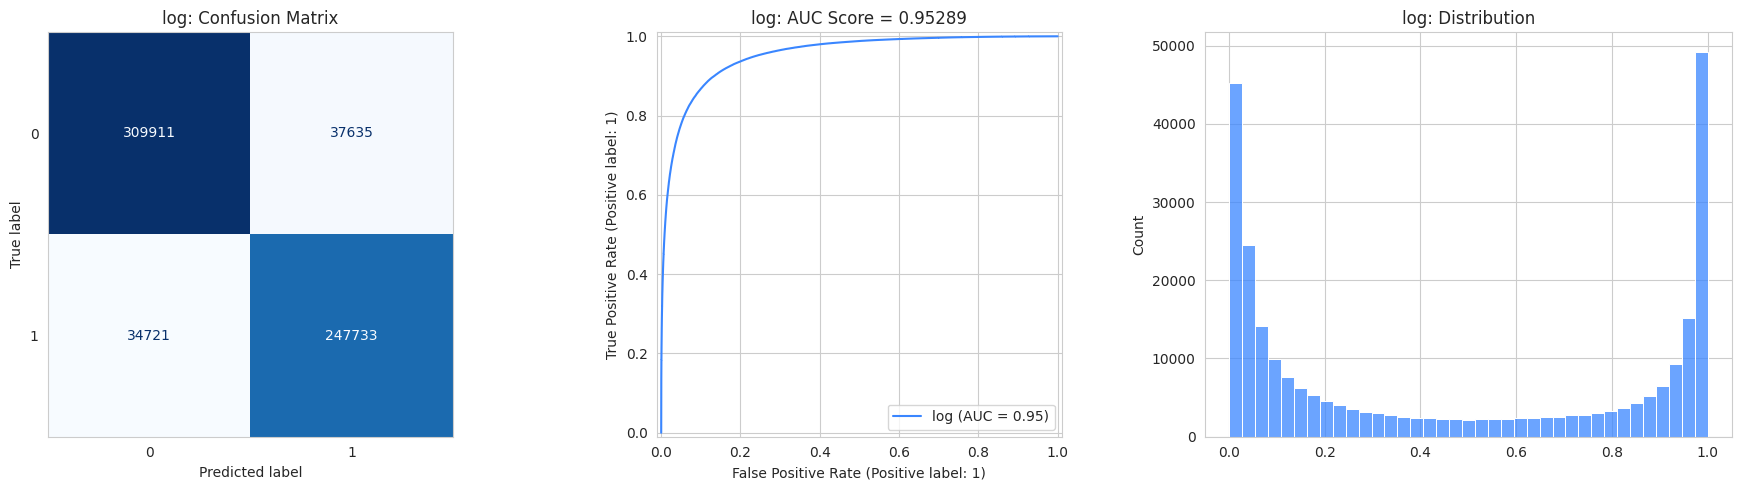


[2] mlp ████████████████████████████████████████


	Fold 1/5 AUC: 0.95378


	Fold 2/5 AUC: 0.95420


	Fold 3/5 AUC: 0.95481


	Fold 4/5 AUC: 0.95343


	Fold 5/5 AUC: 0.95406


|------------------------------
| OOF AUC: 0.95406
| AVG AUC: 0.95406 ± 0.00046
|------------------------------
Time: 730.40 secs


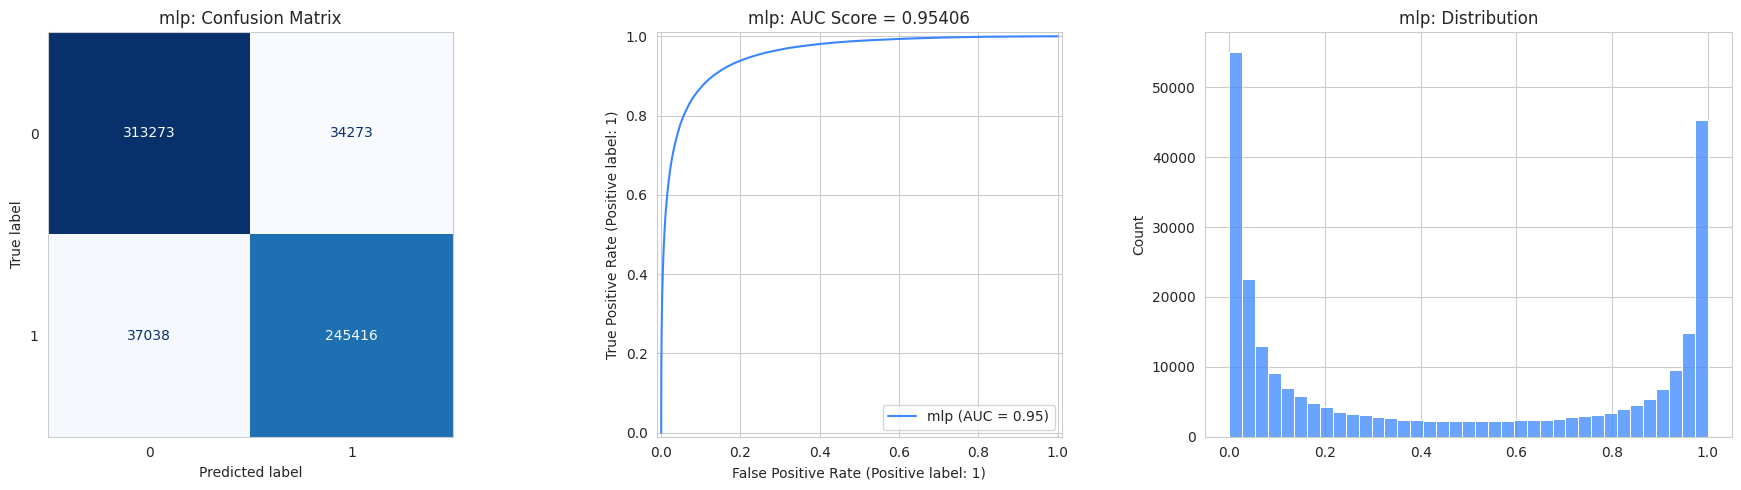

In [35]:
## -- Initiate LINEAR Training 1 -- 
LINEAR_MODELS_1 = {}

for i, (name, model) in tqdm(
    enumerate(linear_models.items()),
    total=len(linear_models),
    desc='Training Models.'
):
    print(f"\n[{i+1}] {COLOR}{name} {'█'*40}{RESET}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_AUCs  = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        X_test = test[FEATURES].copy()

        ## -- Concatenate original data --
        X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        ## -- Create pipeline --
        lr_model = make_pipeline(
            make_column_transformer(
                (OneHotEncoder(
                    handle_unknown='ignore',
                    # sparse_output=False,
                    drop='first',
                ), CATS),
                remainder='passthrough',
                n_jobs=os.cpu_count(),
            ),
            StandardScaler(),
            model,
        )

        lr_model.fit(X, y)
        
        oof_preds[val_idx] = lr_model.predict_proba(X_val)[:,1]
        
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_AUCs.append(fold_auc)
        print(f"\tFold {fold+1}/{kf.n_splits} AUC: {fold_auc:.5f}")

        test_preds += lr_model.predict_proba(X_test)[:,1]

    test_preds /= kf.n_splits
    
    tok = time()
    tiktok = tok-tik
    
    ## -- After all folds --
    overall_AUC = np.round(roc_auc_score(y, oof_preds), 5)
    
    print(f"|{'-'*30}")
    print(f"| OOF AUC: {overall_AUC}")
    print(f"| AVG AUC: {np.mean(fold_AUCs):.5f} ± {np.std(fold_AUCs):.5f}")
    print(f"|{'-'*30}")
    print(f"Time: {tiktok:.2f} secs")
    
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]
    # Right: Confusion matrix (threshold = 0.5)
    pred_labels = (oof_preds >= 0.5).astype('int8')
    ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    axs[0].set_title(f"{name}: Confusion Matrix")
    axs[0].grid(False)
    
    # Left: ROC curve
    RocCurveDisplay.from_predictions(y, oof_preds, name=name, ax=axs[1])
    axs[1].set_title(f"{name}: AUC Score = {overall_AUC}")
    # axs[1].grid(False)

    sns.histplot(test_preds, ax=axs[2])
    axs[2].set_title(f"{name}: Distribution")
    
    plt.tight_layout()
    plt.show()

    n = name + str(overall_AUC).split('.')[1]
    oof_final[n]       = oof_preds
    test_final[n]      = test_preds
    LINEAR_MODELS_1[n] = lr_model
    model_scores[n]    = overall_AUC
    
    gc.collect()

In [36]:
## -- Feature Importances: Linear Model --
for i, name in enumerate(list(LINEAR_MODELS_1.keys())):
    if name == 'log':
        coef_dict = dict(
            zip(
                LINEAR_MODELS_1[name][0].get_feature_names_out(),
                LINEAR_MODELS_1[name][-1].coef_[0]
            )
        )
        # print(coef_dict)
        reg_imp = pd.DataFrame.from_dict(
            coef_dict,
            orient='index',
            columns=['score']
        ).sort_values('score', ascending=False).iloc[:20] # -> Top 10 features
        reg_imp.columns = ['score']
        
        plt.figure(figsize=(16, 8))
        sns.barplot(data=reg_imp, x='score', y=reg_imp.index)
        plt.ylabel('Feature', fontweight='semibold')
        plt.title(f'{name} - Feature importance')
        
        for i, t in enumerate(reg_imp['score'].values):
            plt.text(t+1e-2, i, f'{t:.3f}', fontdict={'size': 12, 'weight': 'bold'})
        
        # plt.tight_layout()
        plt.show()

In [37]:
## -- Define Models --
linear_models2 = {
    'log2v_': LogisticRegressionCV(
        max_iter=1000,
        tol=1e-5, 
        scoring='roc_auc',
        class_weight='balanced',
        n_jobs=os.cpu_count(),
        random_state=SEED,
    ),
    'mlp2v_': MLPClassifier(
        tol=1e-5,
        random_state=SEED,
    ),
}

print(f"Linear Models to train: {len(linear_models2)} -> ", end="")
print(list(linear_models2.keys()))

Linear Models to train: 2 -> ['log2v_', 'mlp2v_']


## ~ LINEAR MODELS 2: OHE ALL FEATURES

Training Models.:   0%|          | 0/2 [00:00<?, ?it/s]


[1] log2v_ ████████████████████████████████████████


	Fold 1/5 AUC: 0.95558


	Fold 2/5 AUC: 0.95587


	Fold 3/5 AUC: 0.95635


	Fold 4/5 AUC: 0.95528


	Fold 5/5 AUC: 0.95559


|------------------------------
| OOF AUC: 0.95573
| AVG AUC: 0.95573 ± 0.00036
|------------------------------
Time: 96.30 secs


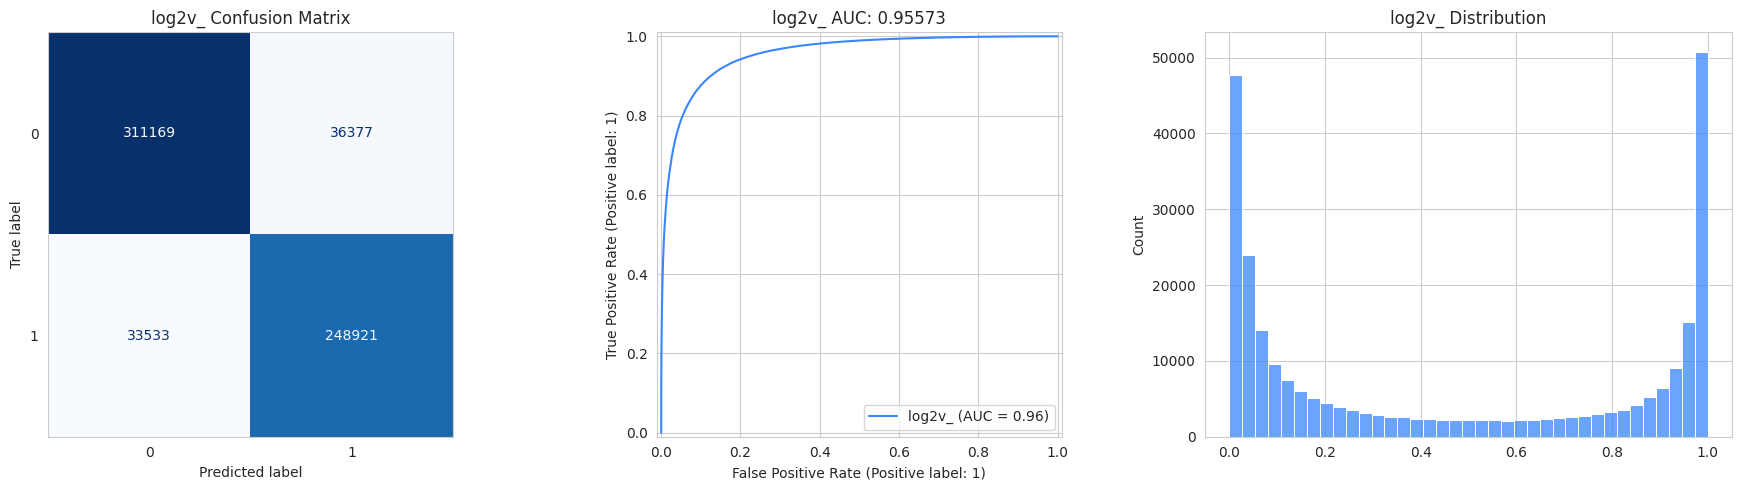


[2] mlp2v_ ████████████████████████████████████████


	Fold 1/5 AUC: 0.96717


	Fold 2/5 AUC: 0.96742


	Fold 3/5 AUC: 0.96793


	Fold 4/5 AUC: 0.96724


	Fold 5/5 AUC: 0.96735


|------------------------------
| OOF AUC: 0.96742
| AVG AUC: 0.96742 ± 0.00027
|------------------------------
Time: 3296.33 secs


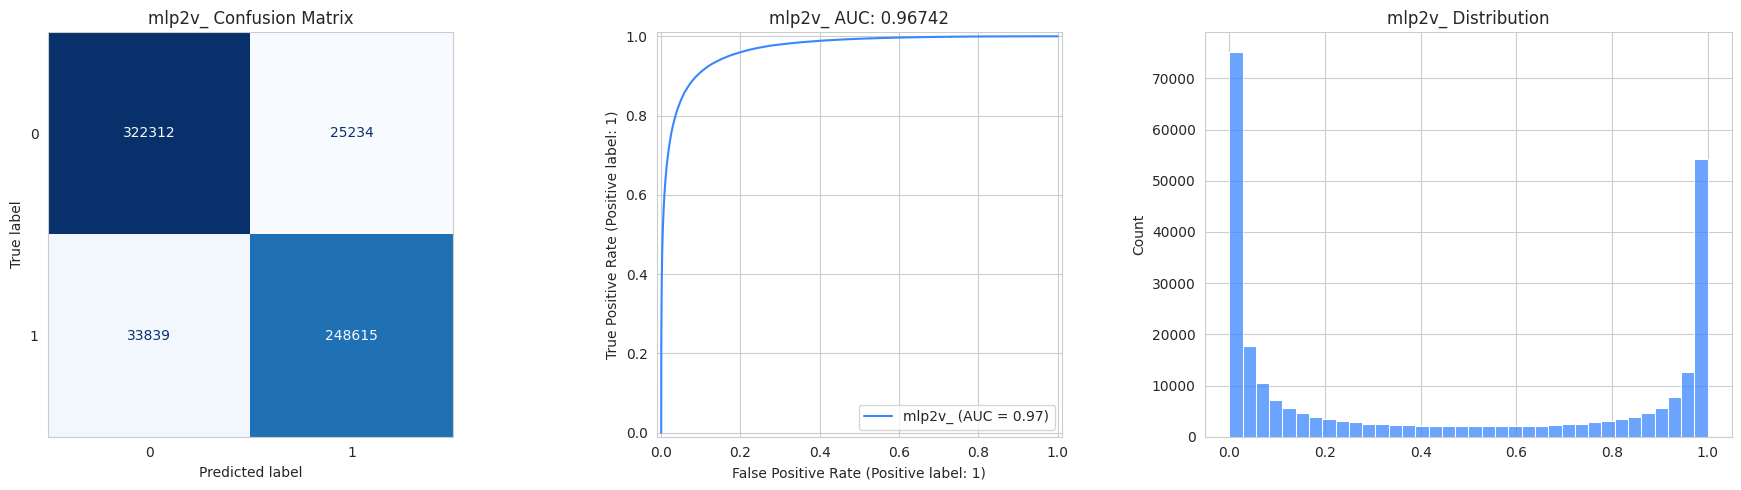

In [38]:
## -- Initiate LINEAR Training 2 -- 
LINEAR_MODELS_2 = {}

for i, (name, model) in tqdm(
    enumerate(linear_models2.items()),
    total=len(linear_models2),
    desc='Training Models.'
):
    print(f"\n[{i+1}] {COLOR}{name} {'█'*40}{RESET}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_AUCs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        X_test = test[FEATURES].copy()

        ## -- Concatenate original data --
        X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        ## -- Create pipeline --
        lr_model = make_pipeline(
            make_column_transformer(
                (OneHotEncoder(
                    handle_unknown='ignore',
                    # sparse_output=False,
                    drop='first',
                ), FEATURES),
                remainder='passthrough',
                n_jobs=os.cpu_count(),
            ),
            StandardScaler(with_mean=False),
            model,
        )

        lr_model.fit(X, y)
        
        oof_preds[val_idx] = lr_model.predict_proba(X_val)[:,1]
        
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_AUCs.append(fold_auc)
        print(f"\tFold {fold+1}/{kf.n_splits} AUC: {fold_auc:.5f}")

        test_preds += lr_model.predict_proba(X_test)[:,1]

    test_preds /= kf.n_splits
    
    tok = time()
    tiktok = tok-tik
    
    ## -- After all folds --
    overall_AUC = np.round(roc_auc_score(y, oof_preds), 5)
    
    print(f"|{'-'*30}")
    print(f"| OOF AUC: {overall_AUC}")
    print(f"| AVG AUC: {np.mean(fold_AUCs):.5f} ± {np.std(fold_AUCs):.5f}")
    print(f"|{'-'*30}")
    print(f"Time: {tiktok:.2f} secs")
    
    _, axs = plt.subplots(1, 3, figsize=(18, 5))
    # Right: Confusion matrix (threshold = 0.5)
    pred_labels = (oof_preds >= 0.5).astype('int8')
    ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    axs[0].set_title(f"{name} Confusion Matrix")
    axs[0].grid(False)
    
    # Left: ROC curve
    RocCurveDisplay.from_predictions(y, oof_preds, name=name, ax=axs[1])
    axs[1].set_title(f"{name} AUC: {overall_AUC}")
    # axs[1].grid(False)

    sns.histplot(test_preds, ax=axs[2])
    axs[2].set_title(f"{name} Distribution")
    
    plt.tight_layout()
    plt.show()

    n = name + str(overall_AUC).split('.')[1]
    oof_final[n]       = oof_preds
    test_final[n]      = test_preds
    LINEAR_MODELS_2[n] = lr_model
    model_scores[n]    = overall_AUC
    
    gc.collect()

In [39]:
## -- Feature Importances: Linear Model --
for i, name in enumerate(list(LINEAR_MODELS_2.keys())):
    if name == 'log':
        coef_dict = dict(
            zip(
                LINEAR_MODELS_2[name][0].get_feature_names_out(),
                LINEAR_MODELS_2[name][-1].coef_[0]
            )
        )
        # print(coef_dict)
        reg_imp = pd.DataFrame.from_dict(
            coef_dict,
            orient='index',
            columns=['score']
        ).sort_values('score', ascending=False).iloc[:30] # -> Top 30 features
        reg_imp.columns = ['score']
        
        plt.figure(figsize=(18, 10))
        sns.barplot(data=reg_imp, x='score', y=reg_imp.index)
        plt.ylabel('Feature', fontweight='semibold')
        plt.title(f'{name} - Feature importance')
        
        for i, t in enumerate(reg_imp['score'].values):
            plt.text(t+1e-2, i, f'{t:.3f}', fontdict={'size': 12, 'weight': 'bold'})
        
        # plt.tight_layout()
        plt.show()

# ~ STACKING


- Stack Fold 1/5 | Models: 9


AUC: 0.96702

- Stack Fold 2/5 | Models: 9


AUC: 0.96731

- Stack Fold 3/5 | Models: 9


AUC: 0.96784

- Stack Fold 4/5 | Models: 9


AUC: 0.96711

- Stack Fold 5/5 | Models: 9


AUC: 0.96725
|------------------------------
| OOF AUC: 0.9673
| AVG AUC: 0.96731 ± 0.00029
|------------------------------
| Time: 29.78 secs


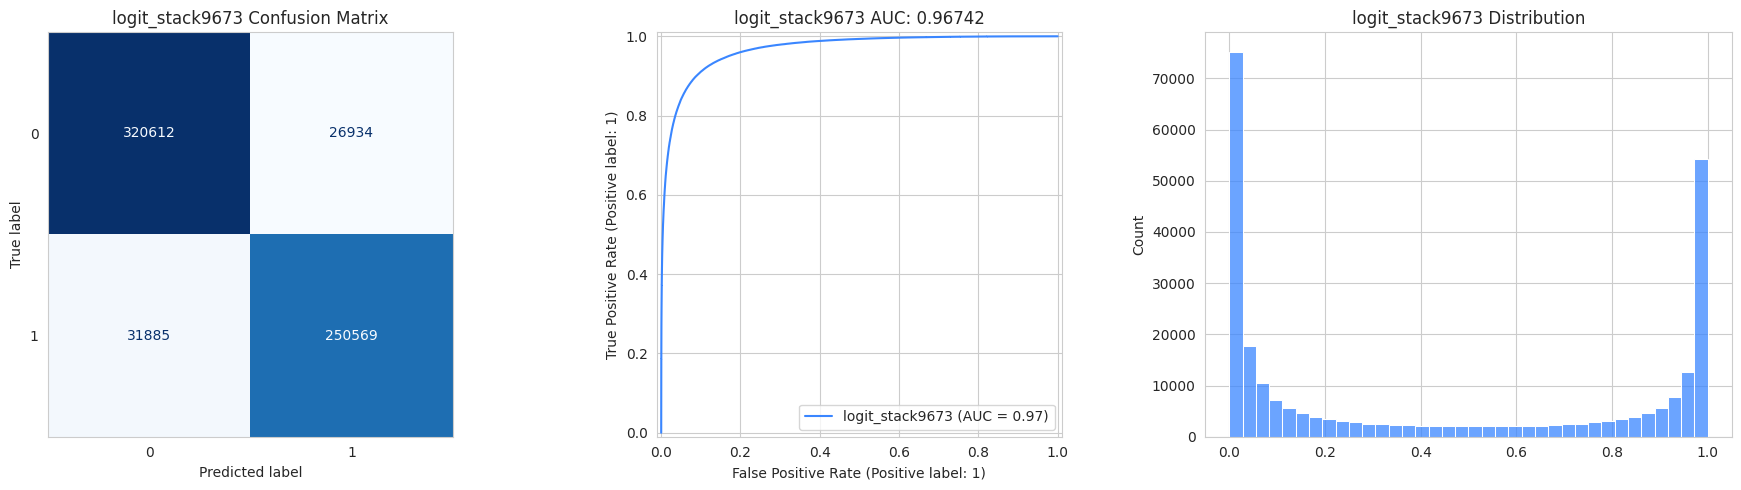

In [40]:
## -- Define Training Parameters --
stack_oof_preds  = np.zeros(len(oof_final))
stack_test_preds = np.zeros(len(test_final))
fold_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

## -- Split data --
X = oof_final
y = train[TARGET].values

## -- Initiate Training --
tik = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n- Stack Fold {fold+1}/{kf.n_splits} | ", end='')
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    X_test = test_final.copy()

    for c in oof_final.columns:
        scaler = StandardScaler()
        X_train[c] = scaler.fit_transform(X_train[[c]], y_train)
        X_val[c]   = scaler.transform(X_val[[c]])
        X_test[c]  = scaler.transform(X_test[[c]])
        
    print(f"Models: {len(X_train.columns)}")
    
    meta_model = LogisticRegressionCV(
        max_iter=1000,
        tol=1e-5,
        random_state=SEED,
        scoring='roc_auc',
        n_jobs=os.cpu_count(),
    ).fit(X_train, y_train)

    stack_oof_preds[val_idx] = meta_model.predict_proba(X_val)[:,1]
    oof_score = np.round(roc_auc_score(y_val, meta_model.predict_proba(X_val)[:,1]), 5)
    fold_scores.append(oof_score)
    print(f"AUC: {oof_score}")

    stack_test_preds += meta_model.predict_proba(X_test)[:,1]

stack_test_preds /= kf.n_splits

tok = time()
tiktok = (tok-tik)

## -- After all folds --
stack_score = np.round(roc_auc_score(y, stack_oof_preds), 5)
stack_name = 'logit_stack' + stack_score.astype(str).split('.')[1]

oof_final[stack_name]    = stack_oof_preds
test_final[stack_name]   = stack_test_preds
model_scores[stack_name] = stack_score

print(f"|{'-'*30}")
print(f"| OOF AUC: {stack_score}")
print(f"| AVG AUC: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}{RESET}")
print(f"|{'-'*30}")
print(f"| Time: {tiktok:.2f} secs")

_, axs = plt.subplots(1, 3, figsize=(18, 5))
# Right: Confusion matrix (threshold = 0.5)
pred_labels = (stack_oof_preds >= 0.5).astype('int8')
ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
axs[0].set_title(f"{stack_name} Confusion Matrix")
axs[0].grid(False)

# Left: ROC curve
RocCurveDisplay.from_predictions(y, stack_oof_preds, name=stack_name, ax=axs[1])
axs[1].set_title(f"{stack_name} AUC: {overall_AUC:.5f}")
# axs[1].grid(False)

sns.histplot(test_preds, ax=axs[2])
axs[2].set_title(f"{stack_name} Distribution")

plt.tight_layout()
plt.show()

# ~ HILLCLIMB

In [41]:
try:
    from hillclimbers import climb_hill, partial
except:
    !pip install -q -U hillclimbers
    from hillclimbers import climb_hill, partial


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [42]:
%%time

## -- Run hillclimber --
hc_test_preds, hc_oof_preds = climb_hill(
        train=train,
        target=TARGET,
        oof_pred_df=oof_final.drop([stack_name], axis=1),
        test_pred_df=test_final.drop([stack_name], axis=1),
        eval_metric=partial(roc_auc_score),
        objective="maximize",
        # negative_weights=True,
        return_oof_preds=True,
        precision=0.01,
        plot_hill=True,
        plot_hist=False,
)


   /\  
  /__\  hillclimbers 
 /    \
/______\ 



Models to be ensembled | (9 total): 

mlp2v_96742: 0.96742 (best solo model)
log2v_95573: 0.95573
cat95531:    0.95531
lgb95476:    0.95476
hst95474:    0.95474
xgb95473:    0.95473
mlp95406:    0.95406
log95289:    0.95289
rfc94694:    0.94694

[Data preparation completed successfully] - [Initiate hill climbing] 



CPU times: user 48.4 s, sys: 2.21 s, total: 50.6 s
Wall time: 50.6 s


In [43]:
hc_score = np.round(roc_auc_score(y, hc_oof_preds), 5)
hc_name = 'hillclimb' + hc_score.astype(str).split('.')[1]

oof_final[hc_name]  = hc_oof_preds
test_final[hc_name] = hc_test_preds

model_scores[hc_name] = hc_score
model_scores.sort_values(inplace=True)
model_scores

rfc94694           0.94694
log95289           0.95289
mlp95406           0.95406
xgb95473           0.95473
hst95474           0.95474
lgb95476           0.95476
cat95531           0.95531
log2v_95573        0.95573
logit_stack9673    0.96730
mlp2v_96742        0.96742
hillclimb96742     0.96742
dtype: float64

,xgb95473,lgb95476,cat95531,rfc94694,hst95474,log95289,mlp95406,log2v_95573,mlp2v_96742,logit_stack9673,hillclimb96742
0,0.994386,0.994202,0.997813,1.00,0.994062,0.997842,0.997689,0.998432,0.999938,0.972320,0.999938
1,0.006982,0.015327,0.011032,0.00,0.014025,0.020837,0.010046,0.012093,0.000827,0.029810,0.000827
2,0.011057,0.017355,0.010503,0.00,0.015861,0.022060,0.016168,0.012103,0.005939,0.031083,0.005939
3,0.061224,0.038277,0.053103,0.04,0.034909,0.064856,0.035727,0.075476,0.218998,0.123904,0.218998
4,0.997556,0.995637,0.998192,1.00,0.995507,0.997901,0.998824,0.997336,0.999762,0.971950,0.999762


,xgb95473,lgb95476,cat95531,rfc94694,hst95474,log95289,mlp95406,log2v_95573,mlp2v_96742,logit_stack9673,hillclimb96742
0,0.954370,0.930644,0.955729,0.830,0.942872,0.914425,0.947135,0.951195,0.918678,0.953837,0.918678
1,0.008005,0.008977,0.006726,0.000,0.008849,0.005877,0.004403,0.011267,0.003363,0.030778,0.003363
2,0.987316,0.983156,0.989553,0.998,0.980815,0.991496,0.993394,0.993704,0.989481,0.971256,0.989481
3,0.007147,0.006733,0.003946,0.004,0.006455,0.006769,0.002712,0.005765,0.002664,0.030176,0.002664
4,0.176082,0.190565,0.200784,0.218,0.191148,0.318105,0.409738,0.209666,0.131279,0.141966,0.131279


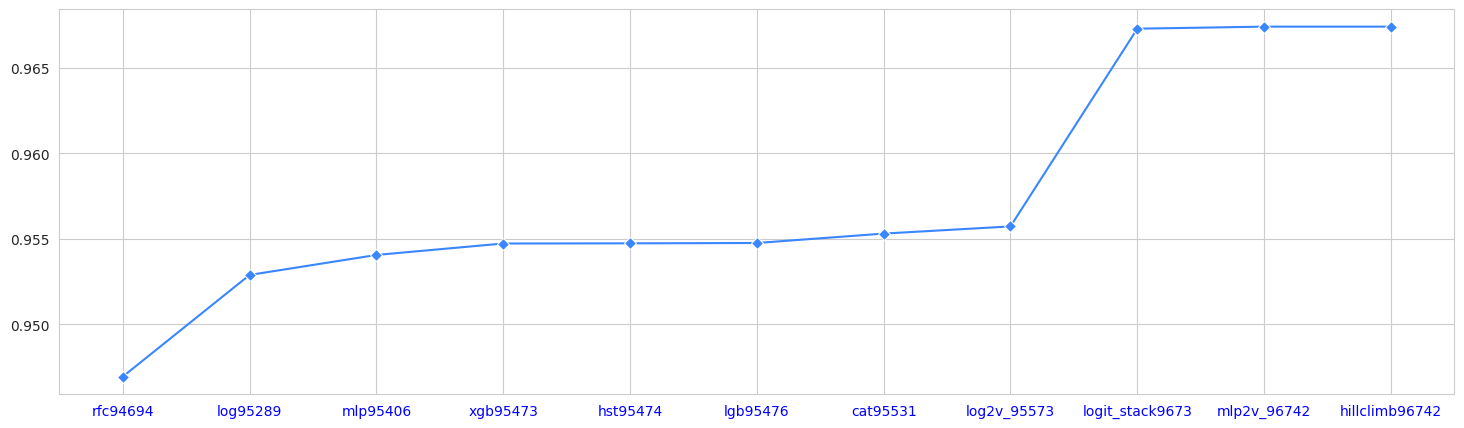

In [44]:
display(oof_final.head())
print()
display(test_final.head())
print()
plt.figure(figsize=(18, 5))
sns.lineplot(model_scores.sort_values(), marker='D')
plt.tick_params(axis='x', labelcolor='b')
# plt.tight_layout()
plt.show()

# SUBMISSION

In [45]:
## -- Export OOF & TEST predictions for each model --
n_oof = f'oof_BASE_hc-stack.parquet'
n_pred = f'test_BASE_hc-stack.parquet'

oof_final.iloc[:, -2:].to_parquet(n_oof, index=False)
test_final.iloc[:, -2:].to_parquet(n_pred, index=False)

print(n_oof, n_pred)

oof_BASE_hc-stack.parquet test_BASE_hc-stack.parquet


In [46]:
## -- Create Submission files --
for i, c in enumerate(test_final.columns):
    submit[TARGET] = test_final[c].values.ravel()
    submit.to_csv(f"submit_BASE_{c}.csv", index=False)
    print(f" -> submit_BASE_{c}.csv file saved!")

 -> submit_BASE_xgb95473.csv file saved!


 -> submit_BASE_lgb95476.csv file saved!


 -> submit_BASE_cat95531.csv file saved!


 -> submit_BASE_rfc94694.csv file saved!


 -> submit_BASE_hst95474.csv file saved!


 -> submit_BASE_log95289.csv file saved!


 -> submit_BASE_mlp95406.csv file saved!


 -> submit_BASE_log2v_95573.csv file saved!


 -> submit_BASE_mlp2v_96742.csv file saved!


 -> submit_BASE_logit_stack9673.csv file saved!


 -> submit_BASE_hillclimb96742.csv file saved!
